## Integració dels fitxers parcials del vot (anys electorals)

In [1]:
# Objectius: llegir tots els fitxers "Vots extrema dreta YYYY.xlsx" (mateixa estructura),
# extreure només: provincia, vots totals i vots "Edreta" (extrema dreta),
# desar parcials per any i crear un CSV agregat (format long amb year + province + total_votes + votes_edreta).

# ---------------------------------------------------------------------
# --- Importació i funcions generals
# ---------------------------------------------------------------------
import re
from pathlib import Path
import pandas as pd
import unicodedata
from typing import List, Optional, Tuple, Dict, Any

pd.options.display.max_columns = 200

def _norm(s: str) -> str:
    if s is None:
        return ""
    s = str(s)
    s = unicodedata.normalize("NFKD", s).encode("ascii", "ignore").decode("ascii")
    s = s.lower().strip()
    s = re.sub(r'\s+', ' ', s)
    return s

def find_col_by_keywords(cols: List[str], keywords: List[str]) -> Optional[str]:
    """ Trobar la primera columna que contingui algun dels keywords"""
    norm_cols = {c: _norm(c) for c in cols}
    for kw in keywords:
        nkw = _norm(kw)
        for orig, ncol in norm_cols.items():
            if nkw == ncol:
                return orig
        for orig, ncol in norm_cols.items():
            if nkw in ncol:
                return orig
    return None

def clean_numeric_series(s: pd.Series) -> pd.Series:
    """Neteja i converteix a numèric una sèrie: elimina punts/comes de milers i separadors."""
    s2 = s.astype(str).str.strip()
    # convertir "—", "-" blancs a NaN
    s2 = s2.replace({'nan': None, 'None': None, '': None})
    # eliminar espais, punts i comes com a separador de milers; mantenir decimals
    s2 = s2.str.replace(r'\s+', '', regex=True)
    # Si els valors tenen coma com a separador decimal assumir enter
    s2 = s2.str.replace(r'\.', '', regex=True)
    s2 = s2.str.replace(r',', '', regex=True)
    return pd.to_numeric(s2, errors='coerce')

def extract_year_from_filename(fname: str) -> Optional[int]:
    m = re.search(r'(19|20)\d{2}', fname)
    return int(m.group(0)) if m else None

# ---------------------------------------------------------------------
# --- Configuració ---
# ---------------------------------------------------------------------
input_dir = r"C:\Users\bfeli\3 BBDD inicials\originals\Excels\Eleccions"
output_csv = r"C:\Users\bfeli\3 BBDD inicials\originals\Excels\Eleccions\merged_votes_edreta.csv"
sheet_name = "Circunscripciones"  
header_row = 0                    
save_partials = True
partials_dir = None               
partials_format = "csv"            

# Auto-detecció:
province_col = None   # ex: "Provincia"  (None = auto)
total_col = None      # ex: "Vots totals" (None = auto)
edreta_col = None     # ex: "Edreta" or "EDRETA" (None = auto)

# Algunes paraules clau per detectar automàticament
province_keywords = ["provincia", "província", "provincia/circunscripcion", "circunscripcion", "circunscripcio", "circunscripció"]
total_keywords = ["vots totals", "vots_total", "votos totales", "total votos", "total", "vots", "votostotals"]
edreta_keywords = ["edreta", "extrema dreta", "extrema-dreta", "extrema", "dreta extrema", "dreta_extrema"]

# ---------------------------------------------------------------------
# --- Processar fitxers (fer la fusió i guardar CSVs parcials)
# ---------------------------------------------------------------------
p = Path(input_dir)
if not p.exists():
    raise FileNotFoundError(f"Directori inputs no localitzat: {input_dir}")

files = sorted([f for f in p.glob("*") if f.suffix.lower() in (".xlsx", ".xls", ".xlsm")])
print("Localitzats", len(files), "Arxius Excel")

# preparar parcials
if save_partials:
    partials_path = Path(partials_dir) if partials_dir else (p / "partials")
    partials_path.mkdir(parents=True, exist_ok=True)
    print("Arxius parcials desats a:", partials_path)
else:
    partials_path = None

rows = []
reports = []

for f in files:
    print("\nTractament:", f.name)
    try:
        df = pd.read_excel(f, sheet_name=sheet_name, header=header_row, engine='openpyxl')
    except Exception as e:
        print("  ERROR al llegir l'arxiu:", e)
        reports.append({"file": f.name, "error": str(e)})
        continue

    # normalitzar noms columnes a strings
    df.columns = [str(c) for c in df.columns]

    # detectar columnes i si no forçar-les
    cols = list(df.columns)
    prov_col = province_col or find_col_by_keywords(cols, province_keywords)
    tot_col = total_col or find_col_by_keywords(cols, total_keywords)
    ed_col = edreta_col or find_col_by_keywords(cols, edreta_keywords)

    report = {
        "file": f.name,
        "detected_province_col": prov_col,
        "detected_total_col": tot_col,
        "detected_edreta_col": ed_col,
        "all_columns_sample": cols[:40]
    }
    reports.append(report)

    # si no trobem alguna columna clau, mostrem i saltem aquest fitxer
    missing = []
    if prov_col is None:
        missing.append("province")
    if tot_col is None:
        missing.append("total_votes")
    if ed_col is None:
        missing.append("votes_edreta")
    if missing:
        print("  No he pogut autodetectar columnes:", missing)
        print("  Columnes disponibles (primeres 40):", cols[:40])
        # desa informe i continuar
        continue

    # extreure any i netejar valors numèrics
    year = extract_year_from_filename(f.name)
    sub = df[[prov_col, tot_col, ed_col]].copy()
    sub = sub.rename(columns={prov_col: "province", tot_col: "total_votes", ed_col: "votes_edreta"})
    sub["year"] = year
    sub["source_file"] = f.name

    # netejar i convertir numèrics
    sub["total_votes"] = clean_numeric_series(sub["total_votes"])
    sub["votes_edreta"] = clean_numeric_series(sub["votes_edreta"])

    # desar parcial
    if save_partials and partials_path is not None:
        stem = re.sub(r'[^0-9A-Za-z._-]+', '_', f.stem)
        outp = partials_path / f"{stem}_{year}_partial.csv"
        try:
            sub.to_csv(outp, index=False, encoding="utf-8")
            print("  Desar parcial:", outp.name)
        except Exception as e:
            print("  Avís: no s'ha pogut desar parcial:", e)

    rows.append(sub)

# concatenar tots els parcials
if not rows:
    raise ValueError("No s'ha processat correctament cap fitxer. Revisa deteccions i especifica province_col/total_col/edreta_col si cal.")

merged = pd.concat(rows, ignore_index=True, sort=False)
# reordenar columnes
merged = merged[["year", "province", "total_votes", "votes_edreta", "source_file"]]

# desa resultat final
try:
    merged.to_csv(output_csv, index=False, encoding="utf-8")
    print("\nDesar combinat CSV a:", output_csv)
except Exception as e:
    print("\nAvís: no s'ha pogut desar CSV combinat:", e)

print("\nEstructura del fitxer:", merged.shape)

# ---------------------------------------------------------------------
# --- Inspecció i agregacions senzilles ---
# ---------------------------------------------------------------------
# Mostrar les primeres files i alguns controls
display(merged.head(20))

# Comprovacions:
# - Fitxers votes_edreta és NaN
missing_ed = merged[merged["votes_edreta"].isna()]
print("\nFiles amb votes_edreta NaN:", len(missing_ed))
if len(missing_ed) > 0:
    display(missing_ed.head(10))

# Aggregació per year (sumes totals)
agg_year = merged.groupby("year")[["total_votes", "votes_edreta"]].sum(min_count=1).reset_index()
print("\nTotal agregats per any:")
display(agg_year)

# Pivot per province x year
pivot = merged.pivot_table(index="province", columns="year", values="votes_edreta", aggfunc="sum", fill_value=0)
print("\nPivot (votes_edreta) preview:")
display(pivot.head(10))
#| include: false

Localitzats 7 Arxius Excel
Arxius parcials desats a: C:\Users\bfeli\3 BBDD inicials\originals\Excels\Eleccions\partials

Tractament: Vots extrema dreta 2000.xlsx
  Desar parcial: Vots_extrema_dreta_2000_2000_partial.csv

Tractament: Vots extrema dreta 2004.xlsx
  Desar parcial: Vots_extrema_dreta_2004_2004_partial.csv

Tractament: Vots extrema dreta 2008.xlsx
  Desar parcial: Vots_extrema_dreta_2008_2008_partial.csv

Tractament: Vots extrema dreta 2011.xlsx
  Desar parcial: Vots_extrema_dreta_2011_2011_partial.csv

Tractament: Vots extrema dreta 2016.xlsx
  Desar parcial: Vots_extrema_dreta_2016_2016_partial.csv

Tractament: Vots extrema dreta 2019.xlsx
  Desar parcial: Vots_extrema_dreta_2019_2019_partial.csv

Tractament: Vots extrema dreta 2023.xlsx
  Desar parcial: Vots_extrema_dreta_2023_2023_partial.csv

Desar combinat CSV a: C:\Users\bfeli\3 BBDD inicials\originals\Excels\Eleccions\merged_votes_edreta.csv

Estructura del fitxer: (364, 5)


,year,province,total_votes,votes_edreta,source_file
0,2000,Almeria,278462,487,Vots extrema dreta 2000.xlsx
1,2000,Cadiz,553667,1001,Vots extrema dreta 2000.xlsx
2,2000,Cordoba,461695,419,Vots extrema dreta 2000.xlsx
3,2000,Granada,480242,378,Vots extrema dreta 2000.xlsx
4,2000,Huelva,245452,311,Vots extrema dreta 2000.xlsx
5,2000,Jaen,399949,397,Vots extrema dreta 2000.xlsx
6,2000,Malaga,649285,722,Vots extrema dreta 2000.xlsx
7,2000,Sevilla,971500,1460,Vots extrema dreta 2000.xlsx
8,2000,Huesca,125449,0,Vots extrema dreta 2000.xlsx
9,2000,Teruel,84252,113,Vots extrema dreta 2000.xlsx



Files amb votes_edreta NaN: 0

Total agregats per any:


,year,total_votes,votes_edreta
0,2000,23181290,31667
1,2004,25891299,65091
2,2008,25734863,60198
3,2011,24348886,73980
4,2016,24053755,58069
5,2019,26201371,2688738
6,2023,24688087,3061683



Pivot (votes_edreta) preview:


year,2000,2004,2008,2011,2016,2019,2023
province,,,,,,,
A Coruña,775,926,1128,0,0,27426,27539
Alacant,485,709,626,0,617,44890,53492
Albacete,370,622,520,0,0,26631,29203
Almeria,487,609,543,493,758,62648,68364
Araba,150,711,341,0,366,16255,17056
Asturias,1075,867,1343,0,1442,72018,74571
Avila,382,831,597,0,255,33948,36750
Badajoz,299,301,427,0,0,11450,8643
Barcelona,2975,4973,5626,53142,0,112019,201775


In [2]:
import pandas as pd
fn = r"C:\Users\bfeli\3 BBDD inicials\originals\Excels\Eleccions\merged_votes_edreta.csv"
df = pd.read_csv(fn)
display(df.head())
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

,year,province,total_votes,votes_edreta,source_file
0,2000,Almeria,278462,487,Vots extrema dreta 2000.xlsx
1,2000,Cadiz,553667,1001,Vots extrema dreta 2000.xlsx
2,2000,Cordoba,461695,419,Vots extrema dreta 2000.xlsx
3,2000,Granada,480242,378,Vots extrema dreta 2000.xlsx
4,2000,Huelva,245452,311,Vots extrema dreta 2000.xlsx


Shape: (364, 5)
Columns: ['year', 'province', 'total_votes', 'votes_edreta', 'source_file']


In [3]:
# - elimina la columna 'source_file' 
# - sobreescriu i desa el mateix fitxer

import shutil
from pathlib import Path
import pandas as pd

# Càrrega del CSV fusionat i configuració
merged_fn = r"C:\Users\bfeli\3 BBDD inicials\originals\Excels\Eleccions\merged_votes_edreta.csv"
backup_before_overwrite = True  # còpia de seguretat
save_as_new = False             # si True, guarda en un fitxer nou enlloc d'sobreescriure
new_filename = merged_fn.replace(".csv", "_nosource.csv")

# --- Execució ---
merged_path = Path(merged_fn)
if not merged_path.exists():
    raise FileNotFoundError(f"Fitxer no trobat: {merged_fn}")

# Backup
if backup_before_overwrite:
    bak = merged_path.with_suffix(".bak.csv")
    shutil.copy(merged_path, bak)
    print(f"Backup creat: {bak}")

# Càrrega
df = pd.read_csv(merged_path, dtype=str)  # llegir com a text per no perdre informació
print("Columns abans:", df.columns.tolist())

# Esborrar columna si existeix
if 'source_file' in df.columns:
    df = df.drop(columns=['source_file'])
    print("Columna 'source_file' eliminada.")
else:
    print("Columna 'source_file' no existeix.")

# Guardar
out_path = Path(new_filename) if save_as_new else merged_path
df.to_csv(out_path, index=False, encoding='utf-8')
print(f"Fitxer guardat a: {out_path}")

# Actualitzar la variable 'merged'
merged = df
print("Variable 'merged' actualitzada. Composició:", merged.shape)

Backup creat: C:\Users\bfeli\3 BBDD inicials\originals\Excels\Eleccions\merged_votes_edreta.bak.csv
Columns abans: ['year', 'province', 'total_votes', 'votes_edreta', 'source_file']
Columna 'source_file' eliminada.
Fitxer guardat a: C:\Users\bfeli\3 BBDD inicials\originals\Excels\Eleccions\merged_votes_edreta.csv
Variable 'merged' actualitzada. Composició: (364, 4)


# Processament dels fitxers originals

In [4]:
# Objectiu: treballar fitxer a fitxer, netejar i convertir a long, desar el parcial net per fer càlculs
# posteriors i integrar-los.

# ---------------------------------------------------------------------
# --- Importar i processos generals
# ---------------------------------------------------------------------
import re
from pathlib import Path
import pandas as pd
import unicodedata
from IPython.display import display
import traceback

pd.options.display.max_columns = 200

def _norm(s: str) -> str:
    if s is None:
        return ""
    s = str(s)
    s = unicodedata.normalize("NFKD", s).encode("ascii", "ignore").decode("ascii")
    s = s.lower().strip()
    s = re.sub(r'\s+', ' ', s)
    return s

def clean_numeric_series_eu(s: pd.Series) -> pd.Series:
    """Neteja números en format europeu ('1.234,00' -> 1234.0)."""
    s2 = s.astype(str).str.strip()
    s2 = s2.replace({'': pd.NA, 'nan': pd.NA, 'None': pd.NA})
    s2 = s2.str.replace(r'\s+', '', regex=True)   # treure espais
    s2 = s2.str.replace(r'\.', '', regex=True)    # treure punts (milers)
    s2 = s2.str.replace(',', '.', regex=False)    # coma decimal -> punt
    return pd.to_numeric(s2, errors='coerce')

# ---------------------------------------------------------------------
# --- Funcions de lectura i inspecció
# ---------------------------------------------------------------------
def read_excel_auto(path: Path, sheet_name=0, header=0):
    """Llegeix .xlsx amb openpyxl, retorna DataFrame."""
    return pd.read_excel(path, sheet_name=sheet_name, header=header, engine='openpyxl')

def read_csv_auto(path: Path, sep=None, header=0, encoding='utf-8'):
    """Llegeix CSV; sep=None """
    return pd.read_csv(path, sep=sep, header=header, engine='python', encoding=encoding)

def inspect_file_preview(path: Path, nrows=8, header_none=True):
    """Mostrar primeres nfiles sense header i amb header=0."""
    print("Arxiu:", path.name)
    suffix = path.suffix.lower()
    if suffix in ('.xlsx', '.xls', '.xlsm'):
        wb = pd.ExcelFile(path, engine='openpyxl')
        print("Fulls:", wb.sheet_names)
        if header_none:
            raw = pd.read_excel(path, sheet_name=wb.sheet_names[0], header=None, engine='openpyxl')
            print("Vista (header=None):")
            display(raw.head(nrows))
        df0 = pd.read_excel(path, sheet_name=wb.sheet_names[0], header=0, engine='openpyxl')
        print("Vista amb header=0:")
        display(df0.head(nrows))
    elif suffix == '.csv':
        with open(path, 'r', encoding='utf-8', errors='ignore') as fh:
            lines = [next(fh) for _ in range(min(20, nrows+5))]
        print("Vista prèvia (primeres files):")
        print("".join(lines))
        try:
            df0 = pd.read_csv(path, header=0, sep=None, engine='python', encoding='utf-8', nrows=nrows)
        except Exception:
            df0 = pd.read_csv(path, header=0, sep=';', engine='python', encoding='cp1252', nrows=nrows)
        print("Vista anàlisi (header=0):")
        display(df0.head(nrows))
    else:
        raise ValueError("Format no suportat per inspect_file_preview")

# ---------------------------------------------------------------------
# --- Funció per convertir un fitxer wide->long i desar parcial
# ---------------------------------------------------------------------
def process_single_file_to_long(path: Path,
                                sheet_name=None,       # per xlsx; None -> primer full
                                header_row=0,
                                first_col_is_years=True,
                                province_col_override=None,
                                year_cols_override=None,
                                metric_name=None,      # nom curt per indicar mètrica, ex "denuncies"
                                save_partial=True,
                                partials_dir: Path = None,
                                drop_meta_cols: bool = True,
                                out_encoding='utf-8'):
    """
    Processa un únic fitxer i retorna (df_long).
    - Si first_col_is_years=True: s'espera que la primera columna contingui ANYS (fitxers originals en excel).
      Llavors fem melt amb id_vars=[first_col] i var_name='province'.
    - Si first_col_is_years=False: s'espera files=províncies i cols=anys; fer melt amb id_vars=[province_col].
    - drop_meta_cols: si True, elimina 'source_file' i 'metric' abans de desar el parcial (perquè només variables clau).
    - Retorna DataFrame long i torna dict.
    """
    path = Path(path)
    suffix = path.suffix.lower()
    # Lectura
    if suffix in ('.xlsx', '.xls', '.xlsm'):
        if sheet_name is None:
            wb = pd.ExcelFile(path, engine='openpyxl')
            sheet_name_use = wb.sheet_names[0]
        else:
            sheet_name_use = sheet_name
        df = pd.read_excel(path, sheet_name=sheet_name_use, header=header_row, engine='openpyxl')
    elif suffix == '.csv':
        # intentar amb utf-8 i sep=';' per a fitxers europeus; fallback cp1252
        try:
            df = pd.read_csv(path, header=header_row, sep=None, engine='python', encoding='utf-8')
        except Exception:
            df = pd.read_csv(path, header=header_row, sep=';', engine='python', encoding='cp1252')
    else:
        raise ValueError("Format no suportat: " + suffix)

    # assegurar columnes textuals
    df.columns = [str(c) for c in df.columns]
    cols = list(df.columns)

    # Disseny: files són anys -> first_col_is_years True (Any a la primera columna)
    if first_col_is_years:
        year_col = cols[0]
        province_cols = cols[1:] if len(cols) > 1 else []
        if not province_cols:
            raise ValueError("No s'han detectat columnes província quan s'esperaven anys en la 1a columna.")
        df_long = df.melt(id_vars=[year_col], value_vars=province_cols, var_name='province', value_name='value')
        df_long = df_long.rename(columns={year_col: 'year'})
    else:
        # files = provinces; columns = anys
        province_col = province_col_override or cols[0]
        year_cols = year_cols_override or cols[1:]
        df_long = df.melt(id_vars=[province_col], value_vars=year_cols, var_name='year', value_name='value')
        df_long = df_long.rename(columns={province_col: 'province'})

    # netejar i estàndarditzar
    df_long['year'] = df_long['year'].astype(str).str.extract(r'((19|20)\d{2})', expand=False)[0].fillna(df_long['year'].astype(str))
    df_long['province'] = df_long['province'].astype(str).str.strip()
    df_long['value'] = clean_numeric_series_eu(df_long['value'])
    df_long['source_file'] = path.name
    df_long['metric'] = metric_name if metric_name else path.stem

    # eliminar columnes informatives abans de desar
    if drop_meta_cols:
        df_to_save = df_long.drop(columns=[c for c in ['source_file','metric'] if c in df_long.columns])
    else:
        df_to_save = df_long

    report = {
        'file': path.name,
        'rows_input': df.shape[0],
        'cols_input': len(cols),
        'rows_output': df_long.shape[0],
        'metric': metric_name if metric_name else path.stem,
        'drop_meta_cols': drop_meta_cols
    }

    # desar parcial
    if save_partial:
        if partials_dir is None:
            partials_dir = path.parent / 'partials_individuals'
        partials_dir = Path(partials_dir)
        partials_dir.mkdir(parents=True, exist_ok=True)
        outp = partials_dir / f"{path.stem}_long.csv"
        df_to_save.to_csv(outp, index=False, encoding=out_encoding)
        report['partial_saved'] = str(outp)
        report['partial_shape'] = df_to_save.shape

    return df_long, report

# ---------------------------------------------------------------------
# ---  Processar un fitxer
# ---------------------------------------------------------------------
# processar un fitxer .xlsx
file_path = r"C:\Users\bfeli\3 BBDD inicials\originals\Excels\Denuncies.xlsx"
# Paràmetres:
sheet_name = None          # None -> primer full
header_row = 0             # ajustar si la capçalera NO és a la primera fila
first_col_is_years = True  # files = ANYS; columns = províncies
metric_name = "denuncies"  # etiqueta
save_partial = True
drop_meta_cols = True      # elimina 'source_file' i 'metric' abans de desar
partials_dir = r"C:\Users\bfeli\3 BBDD inicials\originals\Excels\partials_individuals"

# Executar
try:
    df_long_single, rpt_single = process_single_file_to_long(
        Path(file_path),
        sheet_name=sheet_name,
        header_row=header_row,
        first_col_is_years=first_col_is_years,
        metric_name=metric_name,
        save_partial=save_partial,
        partials_dir=partials_dir,
        drop_meta_cols=drop_meta_cols
    )
    print("Fitxer processat:", rpt_single['file'])
    print("Files input:", rpt_single['rows_input'], "Files output:", rpt_single['rows_output'])
    if 'partial_saved' in rpt_single:
        print("Parcial desat a:", rpt_single['partial_saved'])
    display(df_long_single.head(12))
except Exception as e:
    print("Error processant l'arxiu:", e)
    traceback.print_exc()

# ---------------------------------------------------------------------
# --- Comprovar els parcials i fer càlculs individuals
# ---------------------------------------------------------------------
partials_dir = Path(partials_dir)
print("Parcials dir:", partials_dir, "existeix:", partials_dir.exists())
if partials_dir.exists():
    partial_files = sorted([p.name for p in partials_dir.glob("*.csv")])
    print("Parcials arxius (mostra):", partial_files[:40])
    # Carregar un parcial per fer càlculs individuals
    if partial_files:
        sample = partials_dir / partial_files[0]
        print("\Vista de", sample.name)
        df_sample = pd.read_csv(sample, encoding='utf-8')
        display(df_sample.head(12))
else:
    print("Encara no hi ha parcials. Executar codi anterior per generar-los.")

Fitxer processat: Denuncies.xlsx
Files input: 22 Files output: 1144
Parcial desat a: C:\Users\bfeli\3 BBDD inicials\originals\Excels\partials_individuals\Denuncies_long.csv


,year,province,value,source_file,metric
0,2003,Almeria,12780.0,Denuncies.xlsx,denuncies
1,2004,Almeria,13770.0,Denuncies.xlsx,denuncies
2,2005,Almeria,10490.0,Denuncies.xlsx,denuncies
3,2006,Almeria,26660.0,Denuncies.xlsx,denuncies
4,2007,Almeria,22980.0,Denuncies.xlsx,denuncies
5,2008,Almeria,24810.0,Denuncies.xlsx,denuncies
6,2009,Almeria,26040.0,Denuncies.xlsx,denuncies
7,2010,Almeria,27520.0,Denuncies.xlsx,denuncies
8,2011,Almeria,23570.0,Denuncies.xlsx,denuncies
9,2012,Almeria,21230.0,Denuncies.xlsx,denuncies


Parcials dir: C:\Users\bfeli\3 BBDD inicials\originals\Excels\partials_individuals existeix: True
Parcials arxius (mostra): ['Denuncies_long.csv', 'Ordres_long.csv', 'atur_annual_by_province_unweighted.csv', 'atur_annual_unweighted.csv', 'debug_pop_atur_merge_sample.csv', 'feminicidis_long.csv', 'immigracio_long.csv', 'imputed_rates_all_metrics_by_province_year_unified_final_recomputed_rates.csv', 'inspect_summary.csv', 'missing_pct_overall.csv', 'missing_summary_chosen_file.csv', 'poblacio_long.csv', 'population_imputed_linear.csv', 'population_imputed_linear_with_province.csv', 'population_imputed_national_growth.csv', 'preview_top1_dataset_locf_2024_csv.csv', 'preview_top2_dataset_original_csv.csv', 'preview_top3_processed_dataset_original_csv.csv', 'process_report_individuals.csv', 'processed_dataset_no2000.csv', 'processed_dataset_no2024.csv', 'rates_all_metrics_by_province_year_unified_final_recomputed_rates.csv', 'rates_all_metrics_by_province_year_unified_final_recomputed_rates

,year,province,value
0,2003,Almeria,12780.0
1,2004,Almeria,13770.0
2,2005,Almeria,10490.0
3,2006,Almeria,26660.0
4,2007,Almeria,22980.0
5,2008,Almeria,24810.0
6,2009,Almeria,26040.0
7,2010,Almeria,27520.0
8,2011,Almeria,23570.0
9,2012,Almeria,21230.0


In [5]:
# Processar feminicidis.xlsx (files = províncies, columnes = anys)
# Objectiu: convertir wide->long amb columnes (province, year, value) i desar parcial net
# Ruta per defecte: C:\Users\bfeli\3 BBDD inicials\originals\Excels\feminicidis.xlsx

# ---------------------------------------------------------------------
# --- Importació i codi general
# ---------------------------------------------------------------------
import re
from pathlib import Path
import pandas as pd
import unicodedata
from IPython.display import display
import traceback

pd.options.display.max_columns = 200

def clean_numeric_series_eu(s: pd.Series) -> pd.Series:
    """Neteja nombres en format europeu (1.234,00 -> 1234.0)."""
    s2 = s.astype(str).str.strip()
    s2 = s2.replace({'': pd.NA, 'nan': pd.NA, 'None': pd.NA})
    s2 = s2.str.replace(r'\s+', '', regex=True)   # treure espais
    s2 = s2.str.replace(r'\.', '', regex=True)    # treure punts (milers)
    s2 = s2.str.replace(',', '.', regex=False)    # coma decimal -> punt
    return pd.to_numeric(s2, errors='coerce')

def detect_year_columns(cols):
    """Retorna en ordre les columnes que semblen anys (4 dígits)"""
    years = []
    for c in cols:
        cstr = str(c).strip()
        m = re.match(r'^(19|20)\d{2}$', cstr)
        if m:
            years.append(c)
        else:
            m2 = re.search(r'(19|20)\d{2}', cstr)
            if m2:
                years.append(c)
    try:
        years_sorted = sorted(years, key=lambda x: int(re.search(r'(19|20)\d{2}', str(x)).group(0)))
    except Exception:
        years_sorted = years
    return years_sorted

# ---------------------------------------------------------------------
# --- Configurar directoris i carpetes
# ---------------------------------------------------------------------
input_path = Path(r"C:\Users\bfeli\3 BBDD inicials\originals\Excels\feminicidis.xlsx")
partials_dir = Path(r"C:\Users\bfeli\3 BBDD inicials\originals\Excels\partials_individuals")
partials_dir.mkdir(parents=True, exist_ok=True)

# ---------------------------------------------------------------------
# --- Inspecció per confirmar capçalera
# ---------------------------------------------------------------------
print("File:", input_path)
# vista de fila sense header per detectar offsets
raw = pd.read_excel(input_path, sheet_name=0, header=None, engine='openpyxl')
print("\nVista prèvia (header=None) (primeres 12 files):")
display(raw.head(12))

# provar headers 0..3 per veure columnes i detectar anys
for hdr in range(0, 4):
    try:
        dfh = pd.read_excel(input_path, sheet_name=0, header=hdr, engine='openpyxl')
    except Exception as e:
        print(f"\ncapçalera={hdr} -> ERROR de lectura: {e}")
        continue
    cols = list(dfh.columns)
    year_cols = detect_year_columns(cols)
    print(f"\ncapçalera={hdr} -> comptador columnes: {len(cols)}; detectades year-columnes (mostra): {year_cols[:8]}")
    print("  mostra columnes (primeres 12):", cols[:12])
    display(dfh.head(4))

# ---------------------------------------------------------------------
# --- Processar wide->long (files = provinces, cols = years) i desar parcial net
# ---------------------------------------------------------------------
# Ajustar header_row si la inspecció ho requereix (0 per defecte)
header_row = 0
sheet_name = 0         # nom del full
province_col = None    # forçar el nom de la columna de província (None -> primera columna)
drop_meta_cols = True  # eliminar source_file/metric abans de desar (només year/province/value)
metric_label = "feminicidis"
out_encoding = "utf-8"

try:
    df = pd.read_excel(input_path, sheet_name=sheet_name, header=header_row, engine='openpyxl')
    df.columns = [str(c) for c in df.columns]
    cols = list(df.columns)
    # Supòsit: files = províncies, columnes = anys (primeres col = provincia)
    # Determinar la columna de província
    prov_col = province_col if province_col in cols else cols[0]
    # Detectar columnes-any entre la resta
    candidate_years = [c for c in cols if c != prov_col]
    detected_years = detect_year_columns(candidate_years)
    # Si no es detecten anys explicitament, assumir columnes restants
    year_cols = detected_years if detected_years else candidate_years

    print("Utilitzant province_col =", prov_col)
    print("Mostra year-columnes:", year_cols[:10])

    # Integrar: id_vars = [province], value_vars = year_cols -> var_name = 'year'
    df_long = df.melt(id_vars=[prov_col], value_vars=year_cols, var_name="year", value_name="value")
    df_long = df_long.rename(columns={prov_col: "province"})
    # netejar i estandarditzar
    df_long["province"] = df_long["province"].astype(str).str.strip()
    df_long["year"] = df_long["year"].astype(str).str.extract(r'((19|20)\d{2})', expand=False)[0].fillna(df_long["year"].astype(str))
    df_long["value"] = clean_numeric_series_eu(df_long["value"])
    df_long["source_file"] = input_path.name
    df_long["metric"] = metric_label

    # Treure columnes informatives abans de desar
    if drop_meta_cols:
        df_to_save = df_long.drop(columns=[c for c in ['source_file','metric'] if c in df_long.columns])
    else:
        df_to_save = df_long

    # Desar parcial sense sobreescriure l'original
    outp = partials_dir / f"{input_path.stem}_long.csv"
    df_to_save.to_csv(outp, index=False, encoding=out_encoding)
    print("Parcial desat a:", outp)
    print("Estructura de la sortida:", df_to_save.shape)

    # Variables de treball
    feminicidis_long = df_long
    feminicidis_clean = df_to_save

    display(df_to_save.head(12))
except Exception as e:
    print("ERROR processant l'arxiu:", e)
    traceback.print_exc()

# ---------------------------------------------------------------------
# --- Comprovacions
# ---------------------------------------------------------------------
if 'feminicidis_clean' in globals():
    dfc = feminicidis_clean
    print("Estructura:", dfc.shape)
    print("Years mostra:", sorted(dfc['year'].dropna().unique())[:10])
    print("Provinces mostra (primeres 10):", sorted(dfc['province'].dropna().unique())[:10])
    print("Valors perduts a 'value':", dfc['value'].isna().sum())
    display(dfc.tail(12))
else:
    print("No localitzat feminicidis_clean - revisar l'error anterior.")

File: C:\Users\bfeli\3 BBDD inicials\originals\Excels\feminicidis.xlsx

Vista prèvia (header=None) (primeres 12 files):


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,Provincia,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
1,Almeria,1,2,2,3,1,1,3,5,6,0,1,2,2,0,3,2,1,0,1,1,1,2
2,Cadiz,3,3,0,1,0,3,1,1,1,0,1,2,0,0,0,0,1,3,2,0,3,0
3,Cordoba,1,4,1,2,1,1,1,1,1,0,2,1,1,0,0,0,4,1,0,1,1,0
4,Granada,1,4,1,5,0,2,2,2,3,1,1,2,2,1,2,5,1,2,1,2,2,1
5,Huelva,0,1,0,0,1,0,2,1,0,0,0,0,0,1,0,1,1,0,0,0,1,0
6,Jaen,3,0,0,3,1,0,0,0,2,2,2,0,1,0,0,1,2,1,1,0,1,0
7,Malaga,2,1,3,4,1,2,5,3,2,2,3,4,4,1,0,2,4,0,2,3,4,5
8,Sevilla,2,4,2,3,3,0,2,4,2,2,1,0,4,2,2,1,1,3,2,4,3,2
9,Huesca,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0



capçalera=0 -> comptador columnes: 23; detectades year-columnes (mostra): ['2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010']
  mostra columnes (primeres 12): ['Provincia', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013']


,Provincia,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Almeria,1,2,2,3,1,1,3,5,6,0,1,2,2,0,3,2,1,0,1,1,1,2
1,Cadiz,3,3,0,1,0,3,1,1,1,0,1,2,0,0,0,0,1,3,2,0,3,0
2,Cordoba,1,4,1,2,1,1,1,1,1,0,2,1,1,0,0,0,4,1,0,1,1,0
3,Granada,1,4,1,5,0,2,2,2,3,1,1,2,2,1,2,5,1,2,1,2,2,1



capçalera=1 -> comptador columnes: 23; detectades year-columnes (mostra): []
  mostra columnes (primeres 12): ['Almeria', 1, 2, '2.1', 3, '1.1', '1.2', '3.1', 5, 6, 0, '1.3']


,Almeria,1,2,2.1,3,1.1,1.2,3.1,5,6,0,1.3,2.2,2.3,0.1,3.2,2.4,1.4,0.2,1.5,1.6,1.7,2.5
0,Cadiz,3,3,0,1,0,3,1,1,1,0,1,2,0,0,0,0,1,3,2,0,3,0
1,Cordoba,1,4,1,2,1,1,1,1,1,0,2,1,1,0,0,0,4,1,0,1,1,0
2,Granada,1,4,1,5,0,2,2,2,3,1,1,2,2,1,2,5,1,2,1,2,2,1
3,Huelva,0,1,0,0,1,0,2,1,0,0,0,0,0,1,0,1,1,0,0,0,1,0



capçalera=2 -> comptador columnes: 23; detectades year-columnes (mostra): []
  mostra columnes (primeres 12): ['Cadiz', 3, '3.1', 0, 1, '0.1', '3.2', '1.1', '1.2', '1.3', '0.2', '1.4']


,Cadiz,3,3.1,0,1,0.1,3.2,1.1,1.2,1.3,0.2,1.4,2,0.3,0.4,0.5,0.6,1.5,3.3,2.1,0.7,3.4,0.8
0,Cordoba,1,4,1,2,1,1,1,1,1,0,2,1,1,0,0,0,4,1,0,1,1,0
1,Granada,1,4,1,5,0,2,2,2,3,1,1,2,2,1,2,5,1,2,1,2,2,1
2,Huelva,0,1,0,0,1,0,2,1,0,0,0,0,0,1,0,1,1,0,0,0,1,0
3,Jaen,3,0,0,3,1,0,0,0,2,2,2,0,1,0,0,1,2,1,1,0,1,0



capçalera=3 -> comptador columnes: 23; detectades year-columnes (mostra): []
  mostra columnes (primeres 12): ['Cordoba', 1, 4, '1.1', 2, '1.2', '1.3', '1.4', '1.5', '1.6', 0, '2.1']


,Cordoba,1,4,1.1,2,1.2,1.3,1.4,1.5,1.6,0,2.1,1.7,1.8,0.1,0.2,0.3,4.1,1.9,0.4,1.10,1.11,0.5
0,Granada,1,4,1,5,0,2,2,2,3,1,1,2,2,1,2,5,1,2,1,2,2,1
1,Huelva,0,1,0,0,1,0,2,1,0,0,0,0,0,1,0,1,1,0,0,0,1,0
2,Jaen,3,0,0,3,1,0,0,0,2,2,2,0,1,0,0,1,2,1,1,0,1,0
3,Malaga,2,1,3,4,1,2,5,3,2,2,3,4,4,1,0,2,4,0,2,3,4,5


Utilitzant province_col = Provincia
Mostra year-columnes: ['2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012']
Parcial desat a: C:\Users\bfeli\3 BBDD inicials\originals\Excels\partials_individuals\feminicidis_long.csv
Estructura de la sortida: (1144, 3)


,province,year,value
0,Almeria,2003,1
1,Cadiz,2003,3
2,Cordoba,2003,1
3,Granada,2003,1
4,Huelva,2003,0
5,Jaen,2003,3
6,Malaga,2003,2
7,Sevilla,2003,2
8,Huesca,2003,0
9,Teruel,2003,1


Estructura: (1144, 3)
Years mostra: ['2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012']
Provinces mostra (primeres 10): ['A Coruña', 'Alacant', 'Albacete', 'Almeria', 'Araba', 'Asturias', 'Avila', 'Badajoz', 'Barcelona', 'Bizkaia']
Valors perduts a 'value': 0


,province,year,value
1132,Lugo,2024,1
1133,Ourense,2024,0
1134,Pontevedra,2024,2
1135,Madrid,2024,4
1136,Murcia,2024,1
1137,Navarra,2024,0
1138,Araba,2024,0
1139,Bizkaia,2024,1
1140,Gipuzkoa,2024,1
1141,La Rioja,2024,1


In [6]:
# Convertir immigracio.xlsx (files = províncies, columnes = anys) a format long
# No sobreescriure l'original: desar un parcial net a .../partials_individuals/immigracio_long.csv

from pathlib import Path
import re
import pandas as pd
import unicodedata
from IPython.display import display

pd.options.display.max_columns = 200

# ---------- Configuració ----------
input_path = Path(r"C:\Users\bfeli\3 BBDD inicials\originals\Excels\immigracio.xlsx")
sheet_name = 0      # posar nom del full si no és el primer
header_row = 0      # 0-indexed: canvia si la capçalera no és a la primera fila
partials_dir = input_path.parent / "partials_individuals"
partials_dir.mkdir(parents=True, exist_ok=True)
metric_label = "immigrants"
drop_meta_cols = True
out_encoding = "utf-8"

# ---------- Funcions generals ----------
def detect_year_columns(cols):
    """Detecta columnes que contenen anys (ex: '2003', '2004' o amb text que inclou l'any)."""
    years = []
    for c in cols:
        cstr = str(c).strip()
        if re.match(r'^(19|20)\d{2}$', cstr):
            years.append(c)
        else:
            m = re.search(r'(19|20)\d{2}', cstr)
            if m:
                years.append(c)
    # ordenar
    try:
        years_sorted = sorted(years, key=lambda x: int(re.search(r'(19|20)\d{2}', str(x)).group(0)))
    except Exception:
        years_sorted = years
    return years_sorted

def clean_numeric_series_eu(s: pd.Series) -> pd.Series:
    """Neteja nombres en format europeu (1.234,00 -> 1234.0)."""
    s2 = s.astype(str).str.strip()
    s2 = s2.replace({'': pd.NA, 'nan': pd.NA, 'None': pd.NA})
    s2 = s2.str.replace(r'\s+', '', regex=True)   # treure espais
    s2 = s2.str.replace(r'\.', '', regex=True)    # treure punts (milers)
    s2 = s2.str.replace(',', '.', regex=False)    # coma decimal -> punt
    return pd.to_numeric(s2, errors='coerce')

def normalize_province_name(s: str) -> str:
    if pd.isna(s):
        return s
    s2 = str(s)
    s2 = unicodedata.normalize("NFKD", s2).encode("ascii", "ignore").decode("ascii")
    return s2.strip()

# ---------- Lectura i processament ----------
print("Lectura:", input_path)
df = pd.read_excel(input_path, sheet_name=sheet_name, header=header_row, engine='openpyxl')
# assegurar columnes de text
df.columns = [str(c) for c in df.columns]
cols = list(df.columns)

# Suposició: files = províncies, columnes = anys => la primera columna és la província
prov_col = cols[0]
candidate_years = [c for c in cols if c != prov_col]
detected_years = detect_year_columns(candidate_years)
year_cols = detected_years if detected_years else candidate_years

print("Utilitzant province_col =", prov_col)
print("Mostra year columnes:", year_cols[:10])

# integrar wide->long: id_vars = [prov_col], value_vars = year_cols
df_long = df.melt(id_vars=[prov_col], value_vars=year_cols, var_name="year", value_name="value")
df_long = df_long.rename(columns={prov_col: "province"})

# normalitzar i netejar
df_long["province"] = df_long["province"].apply(normalize_province_name)
df_long["year"] = df_long["year"].astype(str).str.extract(r'((19|20)\d{2})', expand=False)[0].fillna(df_long["year"].astype(str))
df_long["value"] = clean_numeric_series_eu(df_long["value"])
df_long["source_file"] = input_path.name
df_long["metric"] = metric_label

# preparar DataFrame net per desar sense columnes informatives
if drop_meta_cols:
    df_to_save = df_long.drop(columns=[c for c in ["source_file", "metric"] if c in df_long.columns])
else:
    df_to_save = df_long

# desar parcial
outp = partials_dir / f"{input_path.stem}_long.csv"
df_to_save.to_csv(outp, index=False, encoding=out_encoding)
print("Parcial desat a:", outp)
print("Estructura de sortida:", df_to_save.shape)

# deixar variables útils
immigracio_long = df_long
immigracio_clean = df_to_save

# mostra
display(df_to_save.head(12))

Lectura: C:\Users\bfeli\3 BBDD inicials\originals\Excels\immigracio.xlsx
Utilitzant province_col = Provincia
Mostra year columnes: ['2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012']
Parcial desat a: C:\Users\bfeli\3 BBDD inicials\originals\Excels\partials_individuals\immigracio_long.csv
Estructura de sortida: (1092, 3)


,province,year,value
0,Albacete,2003,13318
1,Alacant,2003,245883
2,Almeria,2003,56276
3,Araba,2003,10445
4,Asturias,2003,19691
5,Avila,2003,3514
6,Badajoz,2003,7167
7,Illes Balears,2003,126505
8,Barcelona,2003,398459
9,Bizkaia,2003,23908


In [7]:
# Convertir poblacio.xlsx (files = províncies, columnes = anys) a long
# No sobrescriure originals): .../partials_individuals/poblacio_long.csv

# ---------------------------------------------------------------------
# --- Importar i funcions generals
# ---------------------------------------------------------------------
import re
from pathlib import Path
import pandas as pd
import unicodedata
from IPython.display import display
import traceback

pd.options.display.max_columns = 200

def clean_numeric_series_eu(s: pd.Series) -> pd.Series:
    """Neteja nombres en format europeu (1.234,00 -> 1234.0)."""
    s2 = s.astype(str).str.strip()
    s2 = s2.replace({'': pd.NA, 'nan': pd.NA, 'None': pd.NA})
    s2 = s2.str.replace(r'\s+', '', regex=True)   # treure espais
    s2 = s2.str.replace(r'\.', '', regex=True)    # treure punts (milers)
    s2 = s2.str.replace(',', '.', regex=False)    # coma decimal -> punt
    return pd.to_numeric(s2, errors='coerce')

def detect_year_columns(cols):
    """Detecta columnes que contenen anys (ex: '2003', '2004' o amb text que inclou l'any)."""
    years = []
    for c in cols:
        cstr = str(c).strip()
        if re.match(r'^(19|20)\d{2}$', cstr):
            years.append(c)
        else:
            m = re.search(r'(19|20)\d{2}', cstr)
            if m:
                years.append(c)
    try:
        years_sorted = sorted(years, key=lambda x: int(re.search(r'(19|20)\d{2}', str(x)).group(0)))
    except Exception:
        years_sorted = years
    return years_sorted

def normalize_province_name(s: str) -> str:
    """Normalitza noms de província (treu accents i strip)."""
    if pd.isna(s):
        return s
    s2 = str(s)
    s2 = unicodedata.normalize("NFKD", s2).encode("ascii", "ignore").decode("ascii")
    s2 = s2.strip()
    s2 = re.sub(r'\s+', ' ', s2)
    return s2

# ---------------------------------------------------------------------
# --- Configurar paths i paràmetres
# ---------------------------------------------------------------------
input_path = Path(r"C:\Users\bfeli\3 BBDD inicials\originals\Excels\poblacio.xlsx")
sheet_name = 0      # o nom del full si no és el primer
header_row = 0      # 0-indexed: canviar si la capçalera no és la primera fila
partials_dir = input_path.parent / "partials_individuals"
partials_dir.mkdir(parents=True, exist_ok=True)
metric_label = "estrangers"
drop_meta_cols = True
out_encoding = "utf-8"

# ---------------------------------------------------------------------
# --- Revisió
# ---------------------------------------------------------------------
print("Arxiu:", input_path)
raw = pd.read_excel(input_path, sheet_name=sheet_name, header=None, engine='openpyxl')
print("\nVista (header=None) prèvia (primeres 8 files):")
display(raw.head(8))

for hdr in range(0, 3):
    try:
        dfh = pd.read_excel(input_path, sheet_name=sheet_name, header=hdr, engine='openpyxl')
    except Exception as e:
        print(f"capçalera={hdr} -> ERROR de lectura: {e}")
        continue
    cols = list(dfh.columns)
    year_cols = detect_year_columns([c for c in cols if c != cols[0]])
    print(f"\ncapçalera={hdr} -> columnes comptador: {len(cols)}; detectades year-columns mostra: {year_cols[:8]}")
    print("Mostra de columnes (primeres 12):", cols[:12])
    display(dfh.head(3))

# ---------------------------------------------------------------------
# --- Processar wide -> long i desar parcial net
# ---------------------------------------------------------------------
try:
    df = pd.read_excel(input_path, sheet_name=sheet_name, header=header_row, engine='openpyxl')
    df.columns = [str(c) for c in df.columns]
    cols = list(df.columns)

    # Suposició: files = províncies, columnes = anys => la primera columna és la província
    prov_col = cols[0]
    candidate_years = [c for c in cols if c != prov_col]
    detected_years = detect_year_columns(candidate_years)
    year_cols = detected_years if detected_years else candidate_years

    print("Utilitzar province_col =", prov_col)
    print("Year columnes mostra:", year_cols[:10])

    # Melt: province as id, years as variables -> year, value
    df_long = df.melt(id_vars=[prov_col], value_vars=year_cols, var_name="year", value_name="value")
    df_long = df_long.rename(columns={prov_col: "province"})

    # Netejar i estandaritzar
    df_long["province"] = df_long["province"].apply(normalize_province_name)
    df_long["year"] = df_long["year"].astype(str).str.extract(r'((19|20)\d{2})', expand=False)[0].fillna(df_long["year"].astype(str))
    df_long["value"] = clean_numeric_series_eu(df_long["value"])
    df_long["source_file"] = input_path.name
    df_long["metric"] = metric_label

    # Esborrar columnes informatives
    if drop_meta_cols:
        df_to_save = df_long.drop(columns=[c for c in ["source_file", "metric"] if c in df_long.columns])
    else:
        df_to_save = df_long

    # Guardar parcial sense sobreescriure l'original
    outp = partials_dir / f"{input_path.stem}_long.csv"
    df_to_save.to_csv(outp, index=False, encoding=out_encoding)
    print("Parcial desat a:", outp)
    print("Estructura de sortida:", df_to_save.shape)

    # Desar variables
    poblacio_long = df_long
    poblacio_clean = df_to_save

    display(df_to_save.head(12))

except Exception as e:
    print("ERROR pprocessant arxiu:", e)
    traceback.print_exc()

# ---------------------------------------------------------------------
# --- Comprovacions
# ---------------------------------------------------------------------
if 'poblacio_clean' in globals():
    dfc = poblacio_clean
    print("Estructura:", dfc.shape)
    print("Years mostra:", sorted(dfc['year'].dropna().unique())[:12])
    print("Provincies mostra (primeres 10):", sorted(dfc['province'].dropna().unique())[:10])
    print("Valors perduts a 'value':", int(dfc['value'].isna().sum()))
    display(dfc.tail(12))
else:
    print("poblacio_clean no localitzat - revisar l'error anterior.")

Arxiu: C:\Users\bfeli\3 BBDD inicials\originals\Excels\poblacio.xlsx

Vista (header=None) prèvia (primeres 8 files):


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,Provincia,2024,2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003
1,Albacete,389070,387529,385967,386726,387838,387818,388948,390225,391865,394012,396017,399093,401590,400847,399448,397881,394521,389127,383458,379276,374717,370383
2,Alacant,1993289,1955268,1907494,1887036,1877627,1855384,1839319,1836715,1837873,1838578,1848236,1852733,1853209,1844439,1840085,1836134,1817519,1766320,1713934,1661660,1602174,1542318
3,Almeria,760964,753364,739541,730430,724003,714123,707319,704871,700055,694051,690750,692434,689320,686448,680484,673042,659443,642797,627719,603215,577427,560655
4,Araba,338594,336308,333908,333485,332874,330104,327763,325250,322974,321541,320451,320199,320566,319846,317737,315280,310944,306475,302481,298830,294304,290746
5,Asturias,1009599,1006060,1004960,1012117,1018053,1021469,1027091,1033550,1040407,1049328,1058560,1067425,1074304,1075877,1077103,1076280,1071081,1065291,1063488,1062755,1062408,1062320
6,Avila,160463,159764,159102,158898,158819,159237,160104,161782,163669,165694,167265,169373,171365,172771,173370,173818,173290,170206,167950,166166,164651,163549
7,Badajoz,666029,666049,667851,671092,672045,673384,675742,679042,682970,686250,688697,690889,691842,689902,687745,684391,680675,674169,668510,664407,659640,656228



capçalera=0 -> columnes comptador: 23; detectades year-columns mostra: [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010]
Mostra de columnes (primeres 12): ['Provincia', 2024, 2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014]


,Provincia,2024,2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003
0,Albacete,389070,387529,385967,386726,387838,387818,388948,390225,391865,394012,396017,399093,401590,400847,399448,397881,394521,389127,383458,379276,374717,370383
1,Alacant,1993289,1955268,1907494,1887036,1877627,1855384,1839319,1836715,1837873,1838578,1848236,1852733,1853209,1844439,1840085,1836134,1817519,1766320,1713934,1661660,1602174,1542318
2,Almeria,760964,753364,739541,730430,724003,714123,707319,704871,700055,694051,690750,692434,689320,686448,680484,673042,659443,642797,627719,603215,577427,560655



capçalera=1 -> columnes comptador: 23; detectades year-columns mostra: []
Mostra de columnes (primeres 12): ['Albacete', 389070, 387529, 385967, 386726, 387838, 387818, 388948, 390225, 391865, 394012, 396017]


,Albacete,389070,387529,385967,386726,387838,387818,388948,390225,391865,394012,396017,399093,401590,400847,399448,397881,394521,389127,383458,379276,374717,370383
0,Alacant,1993289,1955268,1907494,1887036,1877627,1855384,1839319,1836715,1837873,1838578,1848236,1852733,1853209,1844439,1840085,1836134,1817519,1766320,1713934,1661660,1602174,1542318
1,Almeria,760964,753364,739541,730430,724003,714123,707319,704871,700055,694051,690750,692434,689320,686448,680484,673042,659443,642797,627719,603215,577427,560655
2,Araba,338594,336308,333908,333485,332874,330104,327763,325250,322974,321541,320451,320199,320566,319846,317737,315280,310944,306475,302481,298830,294304,290746



capçalera=2 -> columnes comptador: 23; detectades year-columns mostra: [1907494, 1955268, 1993289]
Mostra de columnes (primeres 12): ['Alacant', 1993289, 1955268, 1907494, 1887036, 1877627, 1855384, 1839319, 1836715, 1837873, 1838578, 1848236]


,Alacant,1993289,1955268,1907494,1887036,1877627,1855384,1839319,1836715,1837873,1838578,1848236,1852733,1853209,1844439,1840085,1836134,1817519,1766320,1713934,1661660,1602174,1542318
0,Almeria,760964,753364,739541,730430,724003,714123,707319,704871,700055,694051,690750,692434,689320,686448,680484,673042,659443,642797,627719,603215,577427,560655
1,Araba,338594,336308,333908,333485,332874,330104,327763,325250,322974,321541,320451,320199,320566,319846,317737,315280,310944,306475,302481,298830,294304,290746
2,Asturias,1009599,1006060,1004960,1012117,1018053,1021469,1027091,1033550,1040407,1049328,1058560,1067425,1074304,1075877,1077103,1076280,1071081,1065291,1063488,1062755,1062408,1062320


Utilitzar province_col = Provincia
Year columnes mostra: ['2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012']
Parcial desat a: C:\Users\bfeli\3 BBDD inicials\originals\Excels\partials_individuals\poblacio_long.csv
Estructura de sortida: (1144, 3)


,province,year,value
0,Albacete,2003,370383
1,Alacant,2003,1542318
2,Almeria,2003,560655
3,Araba,2003,290746
4,Asturias,2003,1062320
5,Avila,2003,163549
6,Badajoz,2003,656228
7,Illes Balears,2003,883410
8,Barcelona,2003,4956072
9,Bizkaia,2003,1125115


Estructura: (1144, 3)
Years mostra: ['2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014']
Provincies mostra (primeres 10): ['A Coruna', 'Alacant', 'Albacete', 'Almeria', 'Araba', 'Asturias', 'Avila', 'Badajoz', 'Barcelona', 'Bizkaia']
Valors perduts a 'value': 0


,province,year,value
1132,Segovia,2024,156620
1133,Sevilla,2024,1968624
1134,Soria,2024,90073
1135,Tarragona,2024,861744
1136,Teruel,2024,135309
1137,Toledo,2024,743165
1138,Valencia,2024,2710808
1139,Valladolid,2024,525116
1140,Zamora,2024,166253
1141,Zaragoza,2024,987763


In [8]:
# Convertir atur.xlsx a long valor trimestral (anyTntrimestre) del percentatge d'atur a anual
from pathlib import Path
import pandas as pd
import re

# ---------- CONFIGURAR ----------
input_path = Path(r"C:\Users\bfeli\3 BBDD inicials\originals\Excels\atur.xlsx")
time_col = "Any - Trimestre"   # columna amb valors tipus "2024T4"
percent_col = None             # "percentatge" (None -> detecta automàticament)
weight_col = None              # "poblacio" (None si no disponible)

output_dir = input_path.parent / "partials_individuals"
output_dir.mkdir(parents=True, exist_ok=True)
out_csv_unweighted = output_dir / "atur_annual_unweighted.csv"
out_csv_weighted = output_dir / "atur_annual_weighted.csv"  # només si weight_col existeix

# ---------- Llegeix fitxer (csv o xlsx) ----------
def read_auto(path: Path):
    if path.suffix.lower() in (".xlsx", ".xls", ".xlsm"):
        return pd.read_excel(path, engine="openpyxl")
    else:
        # provar amb utf-8 i fallback cp1252
        try:
            return pd.read_csv(path, encoding="utf-8", engine="python")
        except Exception:
            return pd.read_csv(path, encoding="cp1252", engine="python")

df = read_auto(input_path)
print("Shape input:", df.shape)
print("Columns:", df.columns.tolist())

# ---------- Localitzar la columna de percentatges ----------
def detect_percent_column(df, exclude_cols):
    # escull la columna amb més valors numèrics després de netejar (% i coma->punt)
    def numeric_ratio(s):
        s2 = s.astype(str).str.strip().str.replace('%','').str.replace(',','.', regex=False).str.replace(r'\s+','', regex=True)
        coerced = pd.to_numeric(s2, errors='coerce')
        return coerced.notna().mean()
    candidates = [c for c in df.columns if c not in exclude_cols]
    ratios = {c: numeric_ratio(df[c]) for c in candidates}
    # retornar la millor si supera 0.5
    best = max(ratios.items(), key=lambda x: x[1])
    return best[0] if best[1] > 0.1 else None

if percent_col is None:
    percent_col = detect_percent_column(df, exclude_cols=[time_col] if time_col in df.columns else [])
    print("Detectar columna de percentatge:", percent_col)

# ---------- Netejar percentatge i extreure any ----------
def clean_percent_series(s):
    s2 = s.astype(str).str.strip()
    s2 = s2.str.replace('%','', regex=False)
    s2 = s2.str.replace(r'\s+','', regex=True)
    s2 = s2.str.replace(',', '.', regex=False)
    return pd.to_numeric(s2, errors='coerce')

if time_col not in df.columns:
    raise KeyError(f"Time columna '{time_col}' no localitzada en les dades. Columnes: {df.columns.tolist()}")

# crear columna year a partir dels 4 primers caràcters (ex. "2024T4" -> 2024)
df['year'] = df[time_col].astype(str).str[:4]
# convertir a int
try:
    df['year'] = df['year'].astype(int)
except Exception:
    pass

# netejar percentatges
if percent_col is None:
    raise KeyError("No detecta la columna de percentatge; especificar percent_col manualment.")
df['percent'] = clean_percent_series(df[percent_col])

# ---------- Mitjana anual (unweighted) ----------
unweighted = df.groupby('year', as_index=False)['percent'].mean().rename(columns={'percent':'annual_mean_pct'})
unweighted['method'] = 'unweighted_mean'
unweighted.to_csv(out_csv_unweighted, index=False, encoding='utf-8')
print("Mitjanes anuals no ponderades guardades a:", out_csv_unweighted)
print(unweighted.head())

# ---------- Mitjana ponderada ----------
if weight_col and weight_col in df.columns:
    # netejar weights si cal (si són nombres)
    df['weight'] = pd.to_numeric(df[weight_col], errors='coerce')
    def weighted_mean(g):
        w = g['weight']
        x = g['percent']
        if w.notna().sum() == 0 or w.sum() == 0:
            return pd.Series({'annual_weighted_pct': x.mean()})
        return pd.Series({'annual_weighted_pct': (x * w).sum() / w.sum()})
    weighted = df.groupby('year').apply(weighted_mean).reset_index()
    weighted['method'] = 'weighted_mean'
    weighted.to_csv(out_csv_weighted, index=False, encoding='utf-8')
    print("Mitjanes anuals ponderades desades a:", out_csv_weighted)
    print(weighted.head())
else:
    print("No s'ha localitzat weight_col. Ometre la mijana ponderada.")
    
# ---------- Notes i comprovacions ----------
print("\nNotes:")
print("- Mitjana no ponderada: mitjana aritmètica dels quatre trimestres existents per any.")

Shape input: (4784, 3)
Columns: ['Provincia', 'Any - Trimestre', 'Percentatge']
Detectar columna de percentatge: Percentatge
Mitjanes anuals no ponderades guardades a: C:\Users\bfeli\3 BBDD inicials\originals\Excels\partials_individuals\atur_annual_unweighted.csv
   year  annual_mean_pct           method
0  2002        10.894423  unweighted_mean
1  2003        11.128702  unweighted_mean
2  2004        10.943942  unweighted_mean
3  2005         9.610962  unweighted_mean
4  2006         8.921587  unweighted_mean
No s'ha localitzat weight_col. Ometre la mijana ponderada.

Notes:
- Mitjana no ponderada: mitjana aritmètica dels quatre trimestres existents per any.


In [9]:
# Assegurar que tots els parcials tenen la columna 'provincia' i processar l'atur (trimestral)

from pathlib import Path
import pandas as pd
import re
import unicodedata
from IPython.display import display

# ----------------- Configuració -------------
excels_dir = Path(r"C:\Users\bfeli\3 BBDD inicials\originals\Excels")
partials_dir = excels_dir / "partials_individuals"
partials_dir.mkdir(parents=True, exist_ok=True)

# ----------------- Funcions generals -----------------
def _norm_prov(s):
    if pd.isna(s): 
        return s
    s2 = str(s)
    s2 = unicodedata.normalize("NFKD", s2).encode("ascii","ignore").decode("ascii")
    s2 = re.sub(r'\s+',' ', s2).strip().lower()
    return s2

def title_from_norm(s):
    if pd.isna(s):
        return s
    # recuperar una versió que es pugui llegir a partir de province_norm
    s2 = str(s)
    s2 = re.sub(r'\s+',' ', s2).strip()
    # Títol majúscules simple (pot perdre accents, però preservem string llegible)
    return s2.title()

def read_tolerant(p: Path):
    if p.suffix.lower() in (".xlsx", ".xls", ".xlsm"):
        return pd.read_excel(p, engine="openpyxl")
    else:
        try:
            return pd.read_csv(p, encoding="utf-8", engine="python")
        except Exception:
            return pd.read_csv(p, encoding="cp1252", engine="python")

# ----------------- Localitzar xifra atur -----------------
def find_atur_raw():
    # Prioritat a fitxer exacte 'atur.csv' / 'atur.xlsx'
    for fname in ("atur.csv", "atur.xlsx", "Atur.csv", "Atur.xlsx"):
        p = excels_dir / fname
        if p.exists():
            return p
    # Si no el troba, cercar qualsevol fitxer amb 'atur' però excloent aquells que semblin agregats
    candidates = []
    for d in (partials_dir, excels_dir):
        if not d.exists():
            continue
        for p in d.rglob("*"):
            if p.is_file() and 'atur' in p.name.lower() and p.suffix.lower() in (".csv",".xlsx",".xls",".xlsm"):
                candidates.append(p)
    if not candidates:
        return None
    # Prioritzar fitxers sense paraules d'agregació
    excludes = ('annual','unweighted','by_province','matrix','merged','annualized')
    filtered = [p for p in candidates if not any(ex in p.name.lower() for ex in excludes)]
    if filtered:
        return sorted(filtered, key=lambda x: str(x))[0]
    # Retornar primers candidat però en advertència
    return sorted(candidates, key=lambda x: str(x))[0]

# ----------------- Processar xifra atur -----------------
def process_atur_raw(atur_path: Path):
    print("Processing atur raw:", atur_path)
    df = read_tolerant(atur_path)
    print(" - shape:", df.shape)
    display(df.head(6))

    # Detectar columnes: de preferència noms exactes
    prov_col = None
    time_col = None
    percent_col = None
    for c in df.columns:
        cl = str(c).lower()
        if 'provinc' in cl or cl == 'provincia' or cl == 'province':
            prov_col = c
        if ('trimest' in cl) or ('any' in cl and 'trimest' in cl) or 'trim' in cl:
            time_col = c
        if 'percent' in cl or '%' in cl or 'atur' in cl or 'tax' in cl:
            percent_col = c
    # si no trobem time_col, buscar valors amb format 2024T1
    if time_col is None:
        for c in df.columns:
            sample = df[c].astype(str).head(50).tolist()
            if any(re.match(r'^(19|20)\d{2}T[1-4]$', str(x).strip()) for x in sample):
                time_col = c
                break
    # fallback heurístic per prov_col i percent_col
    if prov_col is None:
        # columna no numèrica més probable
        best = None
        best_score = -1
        for c in df.columns:
            coerced = pd.to_numeric(df[c].astype(str).str.replace(r'\s+','', regex=True).str.replace(',','.', regex=False), errors='coerce')
            nonnum_ratio = 1 - coerced.notna().mean()
            if nonnum_ratio > best_score:
                best_score = nonnum_ratio
                best = c
        prov_col = best

    if percent_col is None:
        # escollir columna amb major proporció numerica (excloent prov/time)
        scores = {}
        for c in df.columns:
            if c in (prov_col, time_col):
                continue
            coerced = pd.to_numeric(df[c].astype(str).str.replace('%','', regex=False).str.replace(',','.', regex=False), errors='coerce')
            scores[c] = coerced.notna().mean()
        percent_col = max(scores.items(), key=lambda x: x[1])[0]

    print(" - columnes detectades -> province:", prov_col, "; time:", time_col, "; percent:", percent_col)

    # Normalitzar i netejar
    d = df.copy()
    d['province'] = d[prov_col].astype(str).str.strip()
    d['province_norm'] = d['province'].apply(_norm_prov)
    d['year'] = d[time_col].astype(str).str[:4]
    # netejar percentatge (coma -> punt, eliminar %)
    d['percent'] = d[percent_col].astype(str).str.replace('%','', regex=False).str.replace(',','.', regex=False).str.replace(r'\s+','', regex=True)
    d['percent'] = pd.to_numeric(d['percent'], errors='coerce')

    # Agrupar per province_norm i year
    grp = d.groupby(['province_norm','year'], as_index=False).agg(
        atur_annual_mean_pct = ('percent','mean'),
        n_quarters = ('percent','count'),
        sample_province = ('province', lambda x: x.iloc[0])
    )
    grp['complete_year'] = grp['n_quarters'] >= 4

    outp = partials_dir / "atur_annual_by_province_unweighted.csv"
    grp.to_csv(outp, index=False, encoding='utf-8')
    print("Desat per provincia anual atur no ponderat a:", outp)
    display(grp.head(12))
    return grp

# ----------------- Restaurar 'province' a tots els arxius parcials convertits a *_long.csv -----------------
def restore_province_in_partials():
    modified = []
    for p in sorted(partials_dir.glob("*_long.csv")):
        try:
            df = pd.read_csv(p, encoding='utf-8')
        except Exception:
            df = pd.read_csv(p, encoding='cp1252')
        need_save = False
        # Si falta 'province' però hi ha 'province_norm', reconstruir province
        if 'province' not in df.columns and 'province_norm' in df.columns:
            df['province'] = df['province_norm'].apply(title_from_norm)
            need_save = True
        # Si existeix però tot NaN, intentar reconstruir
        if 'province' in df.columns and df['province'].isna().all() and 'province_norm' in df.columns:
            df['province'] = df['province_norm'].apply(title_from_norm)
            need_save = True
        if need_save:
            bak = p.with_suffix(p.suffix + ".bak")
            p.rename(bak)
            df.to_csv(p, index=False, encoding='utf-8')
            modified.append((p.name, bak.name))
            print(f"Provincia restaurada a {p.name} (backup: {bak.name})")
    if not modified:
        print("Cap parcial necessita restaurar la provincia.")
    else:
        print("Parcials modificats:", modified)
    return modified

# ----------------- Execució -----------------
print("1) Restaurar 'province' en parcials *_long.csv si cal...")
modified_partials = restore_province_in_partials()

print("\n2) Cercar i processar fitxer RAW d'atur (trimestral)...")
atur_path = find_atur_raw()
if atur_path is None:
    print("No raw atur localitzat (atur.csv / atur.xlsx).")
    print("Arxius 'atur' trobats a partials/Excels (per referencia):")
    for p in sorted(list(partials_dir.glob("*")) + list(excels_dir.glob("*"))):
        if 'atur' in p.name.lower():
            print(" -", p)
    raise SystemExit("Col·locar el fitxer raw trimestral (atur.csv / atur.xlsx) a la carpeta i torna a executar aquesta cel.la.")
# Si l'arxiu atur localitzat és agregat, emetre advertència.
if any(x in atur_path.name.lower() for x in ('annual','unweighted','by_province','matrix','merged','annualized')):
    print("Avís: l'arxiu localitzat per 'atur' sembla agregat:", atur_path.name)
    print("Col·locar el fitxer trimestral original (amb Provincia i Any - Trimestre com ara '2024T4') anomenat 'atur.csv' o 'atur.xlsx' a la carpeta d'Excels/partials_individuals.")
    # S'intenta processar, però no es poden extreure dates. S'atura aquí.
    raise SystemExit("S'ha trobat el fitxer atur agregat; calen les dades trimestrals en brut per calcular les taxes per província.")

# Processar dades anuals bruts i desar l'arxiu anual per provincia
atur_grp = process_atur_raw(atur_path)

print("\nResultat desat a partials_individuals/atur_annual_by_province_unweighted.csv")
print("Executar el pipeline de càlcul de rates per100k amb la seguretat que 'province' existeix en els parcials.")

1) Restaurar 'province' en parcials *_long.csv si cal...
Cap parcial necessita restaurar la provincia.

2) Cercar i processar fitxer RAW d'atur (trimestral)...
Processing atur raw: C:\Users\bfeli\3 BBDD inicials\originals\Excels\atur.xlsx
 - shape: (4784, 3)


,Provincia,Any - Trimestre,Percentatge
0,Albacete,2024T4,11.37
1,Albacete,2024T3,9.92
2,Albacete,2024T2,10.74
3,Albacete,2024T1,13.23
4,Albacete,2023T4,12.09
5,Albacete,2023T3,9.11


 - columnes detectades -> province: Provincia ; time: Any - Trimestre ; percent: Percentatge
Desat per provincia anual atur no ponderat a: C:\Users\bfeli\3 BBDD inicials\originals\Excels\partials_individuals\atur_annual_by_province_unweighted.csv


,province_norm,year,atur_annual_mean_pct,n_quarters,sample_province,complete_year
0,a coruna,2002,12.8525,4,A Coruña,True
1,a coruna,2003,13.7550,4,A Coruña,True
2,a coruna,2004,14.5075,4,A Coruña,True
3,a coruna,2005,9.6325,4,A Coruña,True
4,a coruna,2006,8.1225,4,A Coruña,True
5,a coruna,2007,8.2225,4,A Coruña,True
6,a coruna,2008,8.9175,4,A Coruña,True
7,a coruna,2009,11.4700,4,A Coruña,True
8,a coruna,2010,13.9800,4,A Coruña,True
9,a coruna,2011,15.8275,4,A Coruña,True



Resultat desat a partials_individuals/atur_annual_by_province_unweighted.csv
Executar el pipeline de càlcul de rates per100k amb la seguretat que 'province' existeix en els parcials.


In [10]:
# Arreglar dtypes i normalitzar abans de fer el merge entre població i atur_out (i altres taules)

from pathlib import Path
import pandas as pd
import unicodedata
import re

excels_dir = Path(r"C:\Users\bfeli\3 BBDD inicials\originals\Excels")
partials_dir = excels_dir / "partials_individuals"

# Funcions generals
def _norm_prov(s):
    if pd.isna(s):
        return s
    s2 = str(s)
    s2 = unicodedata.normalize("NFKD", s2).encode("ascii", "ignore").decode("ascii")
    return re.sub(r'\s+', ' ', s2).strip().lower()

def read_tolerant(p: Path):
    if p.suffix.lower() in (".xlsx", ".xls", ".xlsm"):
        return pd.read_excel(p, engine="openpyxl")
    else:
        try:
            return pd.read_csv(p, encoding="utf-8", engine="python")
        except Exception:
            return pd.read_csv(p, encoding="cp1252", engine="python")

# Carregar els fitxers a fusionar:

pop_path = None
# buscar arxius de població a carpeta excels/partials
for p in list(partials_dir.glob("*pobl*.csv")) + list(partials_dir.glob("*pobl*.xlsx")) + list(excels_dir.glob("*pobl*.csv")) + list(excels_dir.glob("*pobl*.xlsx")):
    pop_path = p
    break
if pop_path is None:
    raise FileNotFoundError("No s'ha trobat fitxer de població a partials_individuals ni a Excels. Inclou el fitxer i torna a executar.")
pop_df = read_tolerant(pop_path)
print("Fitxer de població carregat:", pop_path.name, "shape:", pop_df.shape)

# carregar atur_out si existeix
atur_path = partials_dir / "atur_annual_by_province_unweighted.csv"
if not atur_path.exists():
    raise FileNotFoundError(f"No s'ha trobat {atur_path}. Generar abans atur_annual_by_province_unweighted.csv a partir del raw trimestral.")
atur_out = read_tolerant(atur_path)
print("Atur arxiu carregat:", atur_path.name, "shape:", atur_out.shape)

# dtypes i mostres
print("\nColumnes de població i tipus de dades:")
print(pop_df.dtypes)
print("\nAtur columnes i tipus:")
print(atur_out.dtypes)

print("\Mostra de població (primeres files):")
print(pop_df.head().to_string())
print("\nAtur mostra (primeres files):")
print(atur_out.head().to_string())

# Normalitzar noms de columna comuns
# Si població té 'value' com a columna de població, renombrar a 'population'
if 'value' in pop_df.columns and 'population' not in pop_df.columns:
    pop_df = pop_df.rename(columns={'value':'population'})

# Normalitzar i crear province_norm
if 'province_norm' not in pop_df.columns and 'province' in pop_df.columns:
    pop_df['province_norm'] = pop_df['province'].apply(_norm_prov)
if 'province_norm' not in atur_out.columns and 'province' in atur_out.columns:
    atur_out['province_norm'] = atur_out['province'].apply(_norm_prov)

# Normalitzar year: eliminar espais
def clean_year_col(df, colname):
    df[colname] = df[colname].astype(str).str.strip()
    # extreure 4 dígits si hi ha formats com '2024T1'
    df[colname] = df[colname].str.extract(r'((19|20)\d{2})', expand=False)[0].fillna(df[colname])
    return df

pop_df = clean_year_col(pop_df, 'year')
atur_out = clean_year_col(atur_out, 'year')

# Comprovar si tots els anys són convertibles a int en ambdues taules
def all_years_int(df, col='year'):
    try:
        coerced = pd.to_numeric(df[col], errors='coerce')
        return coerced.notna().all()
    except Exception:
        return False

pop_years_int = all_years_int(pop_df, 'year')
atur_years_int = all_years_int(atur_out, 'year')
print(f"\npop years int? {pop_years_int}, atur years int? {atur_years_int}")

# Estratègia: si ambdues són int-convertibles, convertir a int; sinó convertir ambdues a string
if pop_years_int and atur_years_int:
    pop_df['year'] = pd.to_numeric(pop_df['year'], errors='coerce').astype('Int64')
    atur_out['year'] = pd.to_numeric(atur_out['year'], errors='coerce').astype('Int64')
    print("Columnes year convertides a Int64.")
else:
    pop_df['year'] = pop_df['year'].astype(str)
    atur_out['year'] = atur_out['year'].astype(str)
    print("Çolumnes year convertides a str.")

# Informar de valors únics i discrepàncies abans del merge
print("\nAnys únics a pop_df (mostra):", sorted(pop_df['year'].dropna().unique())[:20])
print("Anys únics a atur_out (mostra):", sorted(atur_out['year'].dropna().unique())[:20])

# Comprovar mismatches de province_norm entre ambdues taules (mostres)
pop_provs = set(pop_df['province_norm'].dropna().unique())
atur_provs = set(atur_out['province_norm'].dropna().unique())
common = pop_provs & atur_provs
only_in_pop = sorted(pop_provs - atur_provs)[:20]
only_in_atur = sorted(atur_provs - pop_provs)[:20]
print(f"\nProvincies: pop={len(pop_provs)}, atur={len(atur_provs)}, common={len(common)}")
print("Mostra de províncies només a població (primeres 20):", only_in_pop)
print("Mostra de provincies només a atur (primeres 20):", only_in_atur)

# Mostrar les files de mismatch per analitzar (primeres 20)
if only_in_atur:
    print("\nMostra de files d'atur amb province_norm no trobades a població:")
    display(atur_out[atur_out['province_norm'].isin(only_in_atur)].head(20))

# Ara fem merge: si les dtypes coincideixen, pandas farà merge correcte
merged = pop_df.merge(atur_out[['province_norm','year','atur_annual_mean_pct','n_quarters']], on=['province_norm','year'], how='left')

print("\nEstructura integrada:", merged.shape)
print("Mostra del merged:")
print(merged.head(12).to_string())

# Desar el resultat per revisar
outp = partials_dir / "debug_pop_atur_merge_sample.csv"
merged.to_csv(outp, index=False, encoding='utf-8')
print("\nMostra combinada desada a:", outp)

Fitxer de població carregat: poblacio_long.csv shape: (1144, 3)
Atur arxiu carregat: atur_annual_by_province_unweighted.csv shape: (1196, 6)

Columnes de població i tipus de dades:
province    object
year         int64
value        int64
dtype: object

Atur columnes i tipus:
province_norm            object
year                      int64
atur_annual_mean_pct    float64
n_quarters                int64
sample_province          object
complete_year              bool
dtype: object
\Mostra de població (primeres files):
   province  year    value
0  Albacete  2003   370383
1   Alacant  2003  1542318
2   Almeria  2003   560655
3     Araba  2003   290746
4  Asturias  2003  1062320

Atur mostra (primeres files):
  province_norm  year  atur_annual_mean_pct  n_quarters sample_province  complete_year
0      a coruna  2002               12.8525           4        A Coruña           True
1      a coruna  2003               13.7550           4        A Coruña           True
2      a coruna  2004     

In [11]:
# Fusionar DataFrames de mètriques agregades en un DataFrame final, integrada i tolerant de `safe_merge`

from pathlib import Path
import pandas as pd
import numpy as np

# -----------------------------
# Funcions generals
# -----------------------------
def _is_integer_like_series(s):
    """Retorna True si la sèrie és de tipus enter o només conté nombres enters (després de coerce)"""
    try:
        if pd.api.types.is_integer_dtype(s.dtype):
            return True
        tmp = pd.to_numeric(s.dropna().astype(str), errors='coerce')
        if tmp.dropna().empty:
            return False
        # Comprovar que tots els valors són enters i no nuls
        return tmp.dropna().apply(float.is_integer).all()
    except Exception:
        return False

def _try_to_int64(series):
    """Intentar convertir sèries a pandes Int64 (nullable). Retorna (converted_series, success_bool)."""
    try:
        conv = pd.to_numeric(series, errors='coerce').astype('Int64')
        non_na_frac = conv.notna().sum() / max(1, len(conv))
        if non_na_frac < 0.5:
            return series, False
        return conv, True
    except Exception:
        return series, False

def _to_str_series(series):
    """Normalitzar sèries a strings, convertir strings NA comunes a pd.NA."""
    s = series.astype(str).str.strip()
    s = s.replace({"nan": pd.NA, "None": pd.NA})
    # convertir la cadena 'nan' produïda per astype a NA
    s = s.where(~s.isin(["nan","None"]), pd.NA)
    return s

def safe_merge(left, right, on, how='left', validate=None, suffixes=('_x','_y')):
    """
    Fusió tolerant: forçar les claus a tipus de dades compatibles abans de la fusió.
    left, right: DataFrames
    on: llisat o clau única
    """
    if isinstance(on, str):
        keys = [on]
    else:
        keys = list(on)

    left = left.copy()
    right = right.copy()

    for k in keys:
        if k not in left.columns or k not in right.columns:
            # Si a un costat li falta la clau, deixa la fusió per generar-la més tard; imprimeix el missatge i continua.
            print(f"Avís: clau '{k}' no present a left o right; merge pot fallar per aquesta clau.")
            continue

        lcol = left[k]
        rcol = right[k]

        # Si són del mateix tipus, però object -> normalitza els espais en blanc
        if lcol.dtype == rcol.dtype:
            if pd.api.types.is_object_dtype(lcol.dtype):
                left[k] = _to_str_series(lcol)
                right[k] = _to_str_series(rcol)
            continue

        # Preferència integer
        l_int_like = _is_integer_like_series(lcol)
        r_int_like = _is_integer_like_series(rcol)

        if l_int_like or r_int_like:
            l_conv, l_ok = _try_to_int64(lcol)
            r_conv, r_ok = _try_to_int64(rcol)
            if l_ok and r_ok:
                left[k] = l_conv
                right[k] = r_conv
                print(f"Forçar la clau'{k}' a Int64 per un merge segur.")
                continue
            # retornar un string si cap de les dues pot ser enter fiable
            left[k] = _to_str_series(lcol)
            right[k] = _to_str_series(rcol)
            print(f"No s'han pogut forçar els dos costats de'{k}' a Int64; tornem al string.")
            continue

       # Retorn per defecte: força tots dos a un string
        left[k] = _to_str_series(lcol)
        right[k] = _to_str_series(rcol)
        print(f"Clau forçada '{k}' a string per merge segur.")

    result = left.merge(right, on=keys, how=how, validate=validate, suffixes=suffixes)
    return result

# -----------------------------
# Merge loop
# -----------------------------
def merge_metrics_into_base(base, agg_metrics, keys=("province_norm","year"), how='left', verbose=True):
    """
    Fusiona cada DataFrame d'agg_metrics a la base utilitzant safe_merge.
    - base: DataFrame amb al menys les claus
    - agg_metrics: mapatge de dict metric_name -> DataFrame que ha de contenir les claus + metric_name
    Retorna merged base.
    """
    if verbose:
        print("Inici merge_metrics_into_base: estructura base:", base.shape)
    for m, dfm in agg_metrics.items():
        if dfm is None:
            if verbose:
                print(f"Salt de la mètrica '{m}': la font es None")
            continue
        if not isinstance(dfm, pd.DataFrame):
            if verbose:
                print(f"Salt de la mètrica '{m}': la font no és un DataFrame (type={type(dfm)})")
            continue

        # required columns check
        required = list(keys) + [m]
        missing_cols = [c for c in required if c not in dfm.columns]
        if missing_cols:
            if verbose:
                print(f"Salt de la mètrica '{m}': falten columnes a la font: {missing_cols}")
            continue

        if verbose:
            print(f"Fusió de mètriques '{m}': left shape {base.shape}, right shape {dfm.shape}")
            try:
                print("  base dtypes:", base[list(keys)].dtypes.to_dict())
                print("  dfm dtypes: ", dfm[list(keys)].dtypes.to_dict())
            except Exception:
                pass

        try:
            # selecciona només les claus + la columna mètrica
            right_sel = dfm.loc[:, list(keys) + [m]]
            base = safe_merge(base, right_sel, on=list(keys), how=how)
            if verbose:
                print(f"  Merged '{m}' -> new base shape: {base.shape}")
        except Exception as e:
            print(f"Error en la fusió de la mètrica '{m}': {e}")
            print("  mostra de la base (claus):")
            print(base.loc[:, list(keys)].head(5))
            print("  right mostra (claus):")
            print(right_sel.loc[:, list(keys)].head(5))
            raise
    if verbose:
        print("S'han acabat de fusionar les mètriques. Forma de la base final:", base.shape)
    return base

In [12]:
# Merge de merged_votes_edreta.csv amb poblacio_long.csv i càlcul de votes_per100k

from pathlib import Path
import pandas as pd
import unicodedata
import re

# Paths
excels_dir = Path(r"C:\Users\bfeli\3 BBDD inicials\originals\Excels")
elec_dir = excels_dir / "Eleccions"
partials_dir = excels_dir / "partials_individuals"
partials_dir.mkdir(parents=True, exist_ok=True)

# Fitxers concrets
candidates_votes = [
    elec_dir / "merged_votes_edreta.csv",
    elec_dir / "merged_votes_edreta.bak.csv",
    partials_dir / "merged_votes_edreta.csv",
    partials_dir / "merged_votes_edreta.bak.csv"
]
# poblacio_long.csv pot estar a partials_individuals o a la carpeta Excels
candidates_pop = [
    partials_dir / "poblacio_long.csv",
    partials_dir / "poblacio_long.xlsx",
    excels_dir / "poblacio_long.csv",
    excels_dir / "poblacio_long.xlsx",
    partials_dir / "poblacio.csv",
    excels_dir / "poblacio.csv"
]

# funcions generals
def read_tolerant(p: Path):
    if not p.exists():
        return None
    if p.suffix.lower() in (".xlsx", ".xls", ".xlsm"):
        return pd.read_excel(p, engine="openpyxl")
    else:
        # provar utf-8 després cp1252
        try:
            return pd.read_csv(p, encoding="utf-8", engine="python")
        except Exception:
            return pd.read_csv(p, encoding="cp1252", engine="python")

def _norm_prov(s):
    if pd.isna(s): return s
    s2 = str(s)
    s2 = unicodedata.normalize("NFKD", s2).encode("ascii","ignore").decode("ascii")
    return re.sub(r'\s+',' ', s2).strip().lower()

# Llegir votes
votes_df = None
votes_path = None
for p in candidates_votes:
    if p.exists():
        votes_df = read_tolerant(p)
        votes_path = p
        break
if votes_df is None:
    # fallback: cercar qualsevol fitxer amb 'merged_votes' o 'votes' en carpeta Eleccions
    for p in elec_dir.glob("**/*"):
        if p.is_file() and 'merged_votes' in p.name.lower() or 'votes' in p.name.lower():
            votes_df = read_tolerant(p)
            votes_path = p
            break

if votes_df is None:
    raise FileNotFoundError("No s'ha trobat merged_votes_edreta.csv. Posar el fitxer a carpeta Eleccions i tornar a executar.")

print("Using votes file:", votes_path)
print("Shape:", votes_df.shape)
print("Columns:", votes_df.columns.tolist())
print(votes_df.head(6).to_string(index=False))

# Detectar i normalitzar columnes en votes_df
# Buscar province col, year col i la columna amb els vots (votes_edreta)
cols = [c for c in votes_df.columns]
prov_col = None
year_col = None
vote_col = None
for c in cols:
    lc = c.lower()
    if 'provinc' in lc or lc == 'province' or lc == 'provincia':
        prov_col = c
    if re.match(r'^(year|any|año|anio)$', lc):
        year_col = c
    if 'votes_edreta' in lc or 'vots_edreta' in lc or ('votes' in lc and 'total' not in lc and 'edreta' in lc) or (lc in ('votes','vots','vots_edreta','votes_edre')):
        vote_col = c

# fallback heurístic per vote_col: triar la columna més numèrica (excloent prov/year)
if vote_col is None:
    numeric_scores = {}
    for c in cols:
        if c in (prov_col, year_col): continue
        coerced = pd.to_numeric(votes_df[c].astype(str).str.replace(',','', regex=False), errors='coerce')
        numeric_scores[c] = coerced.notna().mean()
    if numeric_scores:
        vote_col = max(numeric_scores.items(), key=lambda x: x[1])[0]

if prov_col is None:
    # fallback heurístic: columna amb més valors no numèrics
    best=None; best_score=-1
    for c in cols:
        coerced = pd.to_numeric(votes_df[c].astype(str).str.replace(',','', regex=False), errors='coerce')
        score = 1 - coerced.notna().mean()
        if score > best_score:
            best_score = score; best = c
    prov_col = best

if year_col is None:
    # detectar columnes amb anys com a valors
    for c in cols:
        sample = votes_df[c].astype(str).head(80).tolist()
        if any(re.match(r'^(19|20)\d{2}$', str(x).strip()) for x in sample):
            year_col = c
            break

print("Columnes detectades -> province:", prov_col, " year:", year_col, " votes:", vote_col)

# Normalitzar votes_df: province, province_norm, year, votes
v = votes_df.copy()
v['province'] = v[prov_col].astype(str).str.strip()
v['province_norm'] = v['province'].apply(_norm_prov)
# extreure any 4-digits
if year_col is not None:
    v['year'] = v[year_col].astype(str).str.extract(r'((19|20)\d{2})', expand=False)[0].fillna(v[year_col].astype(str))
else:
    # si no existeix any com a columna, intentar inferir altres
    # per seguretat, deixar com a string
    v['year'] = v.index.astype(str)

v['votes'] = pd.to_numeric(v[vote_col].astype(str).str.replace('.','', regex=False).str.replace(',','', regex=False), errors='coerce')

# Agregar per province_norm×year (per si hi hagués duplicats)
votes_agg = v.groupby(['province_norm','year'], as_index=False).agg(
    votes = ('votes','sum'),
    province = ('province', lambda x: x.iloc[0])
)

out_votes_agg = partials_dir / "votes_by_province_year_from_merged_explicit.csv"
votes_agg.to_csv(out_votes_agg, index=False, encoding='utf-8')
print("\nSaved aggregated votes by province-year to:", out_votes_agg)
print(votes_agg.head(12).to_string(index=False))

# Llegir població (poblacio_long.csv) - intentar primer partials desprès carpeta excels
pop_df = None
pop_path = None
for p in candidates_pop:
    if p.exists():
        pop_df = read_tolerant(p)
        pop_path = p
        break
if pop_df is None:
    # fallback: cerca qualsevol file amb 'pobl' a partials or excels
    for p in list(partials_dir.glob("*")) + list(excels_dir.glob("*")):
        if p.is_file() and 'pobl' in p.name.lower():
            pop_df = read_tolerant(p)
            pop_path = p
            break

if pop_df is None:
    raise FileNotFoundError("No poblacio_long file localitzat. Posa poblacio_long.csv (o similar) a partials_individuals o Excels i tornar a executar.")

print("\nUtilitzar fitxer població:", pop_path)
print("Població estructura:", pop_df.shape)
print("Població columnes:", pop_df.columns.tolist())
print(pop_df.head(6).to_string(index=False))

# Normalitzar fitxer de població: province, year, value (population)
p = pop_df.copy()
# renombrar heurístic
cols_low = [c.lower() for c in p.columns]
if 'value' in p.columns and 'population' not in p.columns:
    p = p.rename(columns={'value':'population'})
# detectar province col si no és exacte
year_col_pop = None
pop_col = None
for c in p.columns:
    lc = c.lower()
    if 'provinc' in lc or lc=='province' or lc=='provincia':
        prov_col_pop = c
    if re.match(r'^(year|any|año|anio)$', lc):
        year_col_pop = c
    if 'pop' in lc or 'habit' in lc or 'pobl' in lc:
        pop_col = c
# fallback heuristics
if prov_col_pop is None:
    for c in p.columns:
        coerced = pd.to_numeric(p[c].astype(str).str.replace(',','', regex=False), errors='coerce')
        if (1 - coerced.notna().mean()) > 0.5:
            prov_col_pop = c; break
if pop_col is None and 'value' in p.columns:
    pop_col = 'value'

if prov_col_pop is None or pop_col is None:
    raise KeyError("No es poden detectar clarament les columnes de població (province/year/population). Columnes: " + str(p.columns.tolist()))

p['province'] = p[prov_col_pop].astype(str).str.strip()
p['province_norm'] = p['province'].apply(_norm_prov)
if year_col_pop is not None:
    p['year'] = p[year_col_pop].astype(str).str.extract(r'((19|20)\d{2})', expand=False)[0].fillna(p[year_col_pop].astype(str))
else:
    # si no hi ha columna year, intentar extreure d'altres columnes per valors
    p['year'] = p.index.astype(str)
p['population'] = pd.to_numeric(p[pop_col], errors='coerce')

pop_small = p[['province_norm','year','province','population']].drop_duplicates()
print("\nPopulation normalized sample:")
print(pop_small.head(12).to_string(index=False))

# Merge votes_agg amb població
# assegurar tipus string per year i province_norm
votes_agg['year'] = votes_agg['year'].astype(str)
votes_agg['province_norm'] = votes_agg['province_norm'].astype(str)
pop_small['year'] = pop_small['year'].astype(str)
pop_small['province_norm'] = pop_small['province_norm'].astype(str)

merged = votes_agg.merge(pop_small, on=['province_norm','year'], how='left', suffixes=('_votes','_pop'))
n_total = len(merged)
n_pop_found = merged['population'].notna().sum()
n_votes_missing_pop = n_total - n_pop_found
print(f"\nMerged votes amb població: total de files {n_total}; population found for {n_pop_found}; missing population for {n_votes_missing_pop} rows.")
print("\nMostra de files amb població faltant (primeres 12):")
print(merged[merged['population'].isna()][['province_votes','province_norm','year']].head(12).to_string(index=False))

# Calcular votes_per100k amb la població localitzada
merged['votes_per100k'] = None
mask = merged['population'].notna() & merged['votes'].notna()
merged.loc[mask, 'votes_per100k'] = merged.loc[mask, 'votes'] / merged.loc[mask, 'population'] * 100000

# Desar els resultats de merged
out_final = partials_dir / "votes_with_population_and_rates.csv"
merged.to_csv(out_final, index=False, encoding='utf-8')
print("\nDesar final merged votes+population a:", out_final)
print("\nVista (primees 12 files):")
print(merged.head(12).to_string(index=False))

Using votes file: C:\Users\bfeli\3 BBDD inicials\originals\Excels\Eleccions\merged_votes_edreta.csv
Shape: (364, 4)
Columns: ['year', 'province', 'total_votes', 'votes_edreta']
 year province  total_votes  votes_edreta
 2000  Almeria       278462           487
 2000    Cadiz       553667          1001
 2000  Cordoba       461695           419
 2000  Granada       480242           378
 2000   Huelva       245452           311
 2000     Jaen       399949           397
Columnes detectades -> province: province  year: year  votes: votes_edreta

Saved aggregated votes by province-year to: C:\Users\bfeli\3 BBDD inicials\originals\Excels\partials_individuals\votes_by_province_year_from_merged_explicit.csv
province_norm year  votes province
     a coruna 2000    775 A Coruña
     a coruna 2004    926 A Coruña
     a coruna 2008   1128 A Coruña
     a coruna 2011      0 A Coruña
     a coruna 2016      0 A Coruña
     a coruna 2019  27426 A Coruña
     a coruna 2023  27539 A Coruña
      alacan

In [13]:
# Assegurar la normalització de província.

from pathlib import Path
import pandas as pd
import unicodedata
import re

# Paths
partials_dir = Path(r"C:\Users\bfeli\3 BBDD inicials\originals\Excels\partials_individuals")
pop_imputed_path = partials_dir / "population_imputed_linear.csv"

def title_from_norm(s):
    if pd.isna(s):
        return s
    s2 = str(s)
    s2 = re.sub(r'\s+',' ', s2).strip()
    # majúscules i minúscules (es poden perdre accents)
    return s2.title()

def _norm_prov(s):
    if pd.isna(s): return s
    s2 = str(s)
    s2 = unicodedata.normalize("NFKD", s2).encode("ascii","ignore").decode("ascii")
    return re.sub(r'\s+',' ', s2).strip().lower()

# Llegir population_imputed_linear.csv
if not pop_imputed_path.exists():
    raise FileNotFoundError(f"No trobat {pop_imputed_path}. Revisa el path.")
pop_df = pd.read_csv(pop_imputed_path, encoding='utf-8')

print("Columnes en population_imputed_linear.csv:", pop_df.columns.tolist())

# Normalitzar noms comuns
# Renombrar 'value' -> 'population'
if 'population' not in pop_df.columns and 'value' in pop_df.columns:
    pop_df = pop_df.rename(columns={'value':'population'})

# Si hi ha 'province_norm' però no 'province', recreem 'province' per facilitar merges i reports
if 'province' not in pop_df.columns and 'province_norm' in pop_df.columns:
    print("Crear 'province' des de 'province_norm' (majúscules, accents es poden perdre).")
    pop_df['province'] = pop_df['province_norm'].apply(title_from_norm)
# Si no hi ha 'province_norm' però hi ha 'province', crear province_norm
if 'province_norm' not in pop_df.columns and 'province' in pop_df.columns:
    pop_df['province_norm'] = pop_df['province'].astype(str).apply(_norm_prov)

# Garantir 'year' com a string 4-digits
if 'year' in pop_df.columns:
    pop_df['year'] = pop_df['year'].astype(str).str.extract(r'((19|20)\d{2})', expand=False)[0].fillna(pop_df['year'].astype(str))
else:
    raise KeyError("No s'ha trobat la columna 'year' a population_imputed_linear.csv.")

# Comprovar que tenim 'population'
if 'population' not in pop_df.columns:
    raise KeyError("No s'ha trobat la columna 'population' a population_imputed_linear.csv (ni 'value').")

# Crear pop_small de forma robusta sense KeyError
pop_small = pop_df[['province_norm','year','population']].drop_duplicates().copy()
# afegir columna 'province' si existeix o reconstituir a partir de province_norm
if 'province' in pop_df.columns:
    # assegurar align
    prov_map = pop_df[['province_norm','province']].drop_duplicates().set_index('province_norm')['province'].to_dict()
    pop_small['province'] = pop_small['province_norm'].map(prov_map)
else:
    pop_small['province'] = pop_small['province_norm'].apply(title_from_norm)

# Desar una versió corregida i evitar el problema en execucions futures
out_fix = partials_dir / "population_imputed_linear_with_province.csv"
pop_small.to_csv(out_fix, index=False, encoding='utf-8')
print("S'ha desat la població corregida a:", out_fix)
print("Mostra de files:")
print(pop_small.head(10).to_string(index=False))

Columnes en population_imputed_linear.csv: ['province_norm', 'year', 'population', 'imputed_population_method', 'population_source_year']
Crear 'province' des de 'province_norm' (majúscules, accents es poden perdre).
S'ha desat la població corregida a: C:\Users\bfeli\3 BBDD inicials\originals\Excels\partials_individuals\population_imputed_linear_with_province.csv
Mostra de files:
province_norm year  population province
     a coruna 2003   1100954.0 A Coruna
     a coruna 2004   1104699.0 A Coruna
     a coruna 2005   1109955.0 A Coruna
     a coruna 2006   1115415.0 A Coruna
     a coruna 2007   1121347.0 A Coruna
     a coruna 2008   1128599.0 A Coruna
     a coruna 2009   1135287.0 A Coruna
     a coruna 2010   1138107.0 A Coruna
     a coruna 2011   1140069.0 A Coruna
     a coruna 2012   1141178.0 A Coruna


In [14]:
# Obtenció del fitxer final

from pathlib import Path
import pandas as pd
import numpy as np
import unicodedata, re

partials = Path(r"C:\Users\bfeli\3 BBDD inicials\originals\Excels\partials_individuals")
out_unified = partials / "rates_all_metrics_by_province_year_unified_fixed.csv"

def _norm_prov(s):
    if pd.isna(s): return s
    s2 = str(s)
    s2 = unicodedata.normalize("NFKD", s2).encode("ascii","ignore").decode("ascii")
    return re.sub(r'\s+',' ', s2).strip().lower()

def read_csv_or_xlsx(p):
    if not p.exists(): return None
    try:
        if p.suffix.lower() in (".xlsx", ".xls"):
            return pd.read_excel(p, engine="openpyxl")
        else:
            return pd.read_csv(p, encoding='utf-8', engine='python')
    except Exception:
        return pd.read_csv(p, encoding='cp1252', engine='python')

# població
pop_path = partials / "population_imputed_linear_with_province.csv"
if not pop_path.exists():
    pop_path = partials / "population_imputed_linear.csv"
pop_df = read_csv_or_xlsx(pop_path)
if pop_df is None:
    raise FileNotFoundError("No s'ha trobat el fitxer de població. Posar-lo a partials_individuals.")
if 'population' not in pop_df.columns and 'value' in pop_df.columns:
    pop_df = pop_df.rename(columns={'value':'population'})
if 'province_norm' not in pop_df.columns and 'province' in pop_df.columns:
    pop_df['province_norm'] = pop_df['province'].astype(str).apply(_norm_prov)
if 'province' not in pop_df.columns and 'province_norm' in pop_df.columns:
    pop_df['province'] = pop_df['province_norm'].apply(lambda s: str(s).title())
pop_df['year'] = pop_df['year'].astype(str).str.extract(r'((19|20)\d{2})', expand=False)[0].fillna(pop_df['year'].astype(str))
pop_df['population'] = pd.to_numeric(pop_df['population'], errors='coerce')
pop_small = pop_df[['province_norm','province','year','population']].drop_duplicates()

# cerca per a la imputació per any més propera
pop_lookup = {}
for pn, g in pop_small.groupby('province_norm'):
    pop_lookup[pn] = list(zip(g['year'].astype(int).tolist(), g['population'].tolist()))

def fill_nearest(pn, y):
    try:
        years = np.array([int(yy) for yy,_ in pop_lookup.get(pn,[])])
        vals = np.array([v for _,v in pop_lookup.get(pn,[])])
        if len(years)==0:
            return np.nan
        idx = np.argmin(np.abs(years - int(y)))
        return float(vals[idx])
    except Exception:
        # fallback global
        all_years = []
        all_vals = []
        for k,v in pop_lookup.items():
            for yy,val in v:
                all_years.append(int(yy)); all_vals.append(val)
        if not all_years:
            return np.nan
        years = np.array(all_years); vals = np.array(all_vals)
        idx = np.argmin(np.abs(years - int(y)))
        return float(vals[idx])

# detectar unió years/provinces
years = set(pop_small['year'].unique())
provs = set(pop_small['province_norm'].unique())

# incloure years/provs des de vots imputats
votes_candidates = [
    partials / "votes_imputed_share_locf_refined.csv",
    partials / "votes_imputed_share_locf.csv",
    partials / "votes_by_province_year_from_merged_explicit.csv",
    partials / "votes_by_province_year_from_merged.csv"
]
votes_df = None
for p in votes_candidates:
    v = read_csv_or_xlsx(p)
    if v is not None:
        votes_df = v.copy()
        if 'province_norm' not in votes_df.columns and 'province' in votes_df.columns:
            votes_df['province_norm'] = votes_df['province'].astype(str).apply(_norm_prov)
        if 'year' in votes_df.columns:
            votes_df['year'] = votes_df['year'].astype(str).str.extract(r'((19|20)\d{2})', expand=False)[0].fillna(votes_df['year'].astype(str))
        provs |= set(votes_df['province_norm'].dropna().unique())
        years |= set(votes_df['year'].dropna().unique())
        break

# incloure fitxers de mètriques detectades
metric_files = {
    "denuncies": partials / "Denuncies_long.csv",
    "ordres": partials / "Ordres_long.csv",
    "feminicidis": partials / "feminicidis_long.csv",
    "immigracio": partials / "immigracio_long.csv"
}
for name, f in metric_files.items():
    if f.exists():
        dfm = read_csv_or_xlsx(f)
        if dfm is not None:
            # normalitzar year/province
            cols = dfm.columns.tolist()
            if 'year' not in cols:
                for c in cols:
                    if dfm[c].astype(str).str.match(r'^(19|20)\d{2}$').any():
                        dfm = dfm.rename(columns={c:'year'}); break
            if 'province' not in cols:
                for c in cols:
                    if dfm[c].dtype == object:
                        dfm = dfm.rename(columns={c:'province'}); break
            if 'province' in dfm.columns:
                dfm['province_norm'] = dfm['province'].astype(str).apply(_norm_prov)
                provs |= set(dfm['province_norm'].dropna().unique())
            if 'year' in dfm.columns:
                dfm['year'] = dfm['year'].astype(str).str.extract(r'((19|20)\d{2})', expand=False)[0].fillna(dfm['year'].astype(str))
                years |= set(dfm['year'].dropna().unique())

years = sorted(str(y) for y in years)
provs = sorted(provs)

# quadrícula
grid = pd.MultiIndex.from_product([provs, years], names=['province_norm','year']).to_frame(index=False)
base = grid.merge(pop_small[['province_norm','province','year','population']], on=['province_norm','year'], how='left')

# imputar la població  més propera 
mask = base['population'].isna()
if mask.any():
    base.loc[mask, 'population'] = base.loc[mask].apply(lambda r: fill_nearest(r['province_norm'], r['year']), axis=1)
base['population_imputed_from_nearest'] = mask

# merge cada metric calculada per100k
for metric, f in metric_files.items():
    if not f.exists():
        continue
    dfm = read_csv_or_xlsx(f)
    # normalitzar a province_norm, year, value
    dfm = dfm.copy()
    # heuristics: renombrar columna numèrica a 'value'
    if 'value' not in dfm.columns:
        # escollir la columna numèrica
        numeric_scores = {}
        for c in dfm.columns:
            numeric_scores[c] = pd.to_numeric(dfm[c], errors='coerce').notna().mean()
        val_col = max(numeric_scores.items(), key=lambda x: x[1])[0]
        dfm = dfm.rename(columns={val_col: 'value'})
    # localitzar la columna province 
    if 'province' not in dfm.columns:
        for c in dfm.columns:
            if dfm[c].dtype == object:
                dfm = dfm.rename(columns={c:'province'}); break
    if 'province' in dfm.columns and 'province_norm' not in dfm.columns:
        dfm['province_norm'] = dfm['province'].astype(str).apply(_norm_prov)
    if 'year' not in dfm.columns:
        for c in dfm.columns:
            if dfm[c].astype(str).str.match(r'^(19|20)\d{2}$').any():
                dfm = dfm.rename(columns={c:'year'}); break
    dfm['year'] = dfm['year'].astype(str).str.extract(r'((19|20)\d{2})', expand=False)[0].fillna(dfm['year'].astype(str))
    dfm['value'] = pd.to_numeric(dfm['value'], errors='coerce')
    agg = dfm.groupby(['province_norm','year'], as_index=False)['value'].sum().rename(columns={'value': metric})
    base = base.merge(agg, on=['province_norm','year'], how='left')
    base[f"{metric}_per100k"] = np.where(base['population'].notna(), base[metric] / base['population'] * 100000, np.nan)

# merge vots
if votes_df is not None:
    # assegurar columna de vots numèrica
    if 'votes' not in votes_df.columns:
        for c in votes_df.columns:
            if c not in ('province','province_norm','year') and pd.to_numeric(votes_df[c], errors='coerce').notna().mean() > 0.5:
                votes_df = votes_df.rename(columns={c:'votes'}); break
    votes_df = votes_df[['province_norm','year','votes']].copy()
    votes_df['votes'] = pd.to_numeric(votes_df['votes'], errors='coerce')
    vagg = votes_df.groupby(['province_norm','year'], as_index=False)['votes'].sum()
    base = base.merge(vagg, on=['province_norm','year'], how='left')
    base['votes_per100k'] = np.where(base['population'].notna(), base['votes'] / base['population'] * 100000, np.nan)

# merge atur
atur_p = partials / "atur_annual_by_province_unweighted.csv"
if atur_p.exists():
    atur = read_csv_or_xlsx(atur_p)
    if 'annual_mean_pct' in atur.columns:
        atur = atur.rename(columns={'annual_mean_pct':'atur_annual_mean_pct'})
    if 'province' in atur.columns and 'province_norm' not in atur.columns:
        atur['province_norm'] = atur['province'].astype(str).apply(_norm_prov)
    atur['year'] = atur['year'].astype(str)
    base = base.merge(atur[['province_norm','year','atur_annual_mean_pct','n_quarters']], on=['province_norm','year'], how='left')
    base['atur_used_pct'] = base['atur_annual_mean_pct']
    base['unemployed_est'] = np.where(base['population'].notna(), (base['atur_used_pct']/100.0) * base['population'], np.nan)
    base['unemployed_per100k'] = np.where(base['population'].notna(), (base['unemployed_est'] / base['population']) * 100000, np.nan)

# Desar i visualitzar
base.to_csv(out_unified, index=False, encoding='utf-8')
print("Desar arxiu unificar a:", out_unified)
print("Files:", len(base))
print("Columnes:", base.columns.tolist())
print("\nVista:")
print(base.head(8).to_string(index=False))

Desar arxiu unificar a: C:\Users\bfeli\3 BBDD inicials\originals\Excels\partials_individuals\rates_all_metrics_by_province_year_unified_fixed.csv
Files: 1196
Columnes: ['province_norm', 'year', 'province', 'population', 'population_imputed_from_nearest', 'denuncies', 'denuncies_per100k', 'ordres', 'ordres_per100k', 'feminicidis', 'feminicidis_per100k', 'immigracio', 'immigracio_per100k', 'votes', 'votes_per100k', 'atur_annual_mean_pct', 'n_quarters', 'atur_used_pct', 'unemployed_est', 'unemployed_per100k']

Vista:
province_norm year province  population  population_imputed_from_nearest  denuncies  denuncies_per100k  ordres  ordres_per100k  feminicidis  feminicidis_per100k  immigracio  immigracio_per100k  votes  votes_per100k  atur_annual_mean_pct  n_quarters  atur_used_pct  unemployed_est  unemployed_per100k
     a coruna 2000      NaN   1100954.0                             True        NaN                NaN     NaN             NaN          NaN                  NaN         NaN        

In [15]:
# Revisar tots els fitxers amb vots per poder realitzar una imputació correcta.
from pathlib import Path
import pandas as pd

partials = Path(r"C:\Users\bfeli\3 BBDD inicials\originals\Excels\partials_individuals")
print("Carpeta:", partials, "existeix:", partials.exists())

votes_files = sorted(list(partials.glob("votes*")) + list(partials.glob("*votes*")))
if not votes_files:
    print("No s'han trobat 'votes*' en la carpeta partials_individuals.")
else:
    print("Trobar fitxers relacionats amb vots (nom | mida bytes | vista de les primeres files):\n")
    for p in votes_files:
        try:
            size = p.stat().st_size
        except Exception:
            size = "?"
        print("----", p.name, "| mida:", size)
        try:
            if p.suffix.lower() == ".csv":
                df = pd.read_csv(p, encoding='utf-8', nrows=6)
            else:
                df = pd.read_excel(p, engine="openpyxl", nrows=6)
            print(df.head(6).to_string(index=False))
        except Exception as e:
            print("  (No s'ha pogut visualitzar el fitxer)", e)
        print()

Carpeta: C:\Users\bfeli\3 BBDD inicials\originals\Excels\partials_individuals existeix: True
Trobar fitxers relacionats amb vots (nom | mida bytes | vista de les primeres files):

---- rates_all_metrics_by_province_year_unified_fixed_voteslocf.csv | mida: 213812
province_norm  year province  population  population_imputed_from_nearest  denuncies  denuncies_per100k  ordres  ordres_per100k  feminicidis  feminicidis_per100k  immigracio  immigracio_per100k  votes  votes_per100k  atur_annual_mean_pct  n_quarters  atur_used_pct  unemployed_est  unemployed_per100k
     a coruna  2000      NaN   1100954.0                             True        NaN                NaN     NaN             NaN          NaN                  NaN         NaN                 NaN  775.0      70.393495                   NaN         NaN            NaN             NaN                 NaN
     a coruna  2003 A Coruna   1100954.0                            False    12540.0        1139.012166     0.0        0.000000        

In [16]:
# Imputació del vots als anys que no hi ha eleccions i afegir descripció
from pathlib import Path
import pandas as pd
import numpy as np
import unicodedata, re

partials = Path(r"C:\Users\bfeli\3 BBDD inicials\originals\Excels\partials_individuals")
# vots d'entrada observats i unificats
votes_obs_p = partials / "votes_by_province_year_from_merged_explicit.csv"
unified_in = partials / "rates_all_metrics_by_province_year_unified_fixed.csv"
out_final = partials / "rates_all_metrics_by_province_year_unified_fixed_voteslocf_final.csv"

def _norm_prov(s):
    if pd.isna(s): return s
    s2 = str(s)
    s2 = unicodedata.normalize("NFKD", s2).encode("ascii","ignore").decode("ascii")
    return re.sub(r'\s+',' ', s2).strip().lower()

def normalize_year_col(ser):
    out = ser.astype(str).str.extract(r'((19|20)\d{2})', expand=False)[0]
    out = out.fillna(ser.astype(str))
    return out.astype(str)

# Carregar vots unificats observats
if not unified_in.exists():
    raise FileNotFoundError("No s'ha trobat l'entrada unificada: " + str(unified_in))
unified = pd.read_csv(unified_in, encoding='utf-8')
if not votes_obs_p.exists():
    raise FileNotFoundError("Vots observats no localitzats: " + str(votes_obs_p))
votes_obs = pd.read_csv(votes_obs_p, encoding='utf-8')

# normalitzar claus
if 'province_norm' not in unified.columns and 'province' in unified.columns:
    unified['province_norm'] = unified['province'].astype(str).apply(_norm_prov)
unified['province_norm'] = unified['province_norm'].astype(str).apply(_norm_prov)
unified['year'] = normalize_year_col(unified['year'])

# preparar votes_obs: localitzar columnes de vots, normalitzar province/year, forçar numèric
v = votes_obs.copy()
# renombrar columnes comuns
if 'votes_imputed' in v.columns:
    v = v.rename(columns={'votes_imputed':'votes'})
if 'votes' not in v.columns:
    # triar la més numèrica
    numeric_scores = {c: pd.to_numeric(v[c], errors='coerce').notna().mean() for c in v.columns}
    # esborrar claus evidents
    for k in list(numeric_scores.keys()):
        if k.lower() in ('province','province_norm','year','province.1'):
            numeric_scores.pop(k, None)
    if numeric_scores:
        best = max(numeric_scores.items(), key=lambda x: x[1])[0]
        v = v.rename(columns={best:'votes'})
# normalitzar province_norm/year
if 'province_norm' not in v.columns and 'province' in v.columns:
    v['province_norm'] = v['province'].astype(str).apply(_norm_prov)
if 'year' in v.columns:
    v['year'] = normalize_year_col(v['year'])
v['votes'] = pd.to_numeric(v['votes'], errors='coerce')

# Tractar zeros com a valors perduts
# Converteix zeros->NaN només per a la imputació.
v.loc[v['votes'] == 0, 'votes'] = np.nan

# Crear una graella completa a partir de claus unificades i fusionar
grid = unified[['province_norm','year']].drop_duplicates().sort_values(['province_norm','year']).reset_index(drop=True)
votes_grid = grid.merge(v[['province_norm','year','votes']], on=['province_norm','year'], how='left')

# Omplir cap endavant i cap enrere per província
votes_grid = votes_grid.sort_values(['province_norm','year'])
votes_grid['votes_ffill'] = votes_grid.groupby('province_norm')['votes'].ffill()
votes_grid['votes_filled'] = votes_grid.groupby('province_norm')['votes_ffill'].bfill()
# on encara hi ha NaN, mantenir-los NaN (no s'han observat per provincia)
votes_grid['votes_imputed_method'] = np.where(votes_grid['votes'].notna(), 'observed', 
                                              np.where(votes_grid['votes_ffill'].notna(), 'locf_bfill', 'missing'))

# escollir valors finals: observed si existeix i sinó emplenar
votes_grid['votes_final'] = votes_grid['votes']
votes_grid.loc[votes_grid['votes_final'].isna(), 'votes_final'] = votes_grid.loc[votes_grid['votes_final'].isna(), 'votes_filled']

# Tornar a combinar i calcular votes_per100k utilitzant unified.population
merged = unified.merge(votes_grid[['province_norm','year','votes_final','votes_imputed_method']], on=['province_norm','year'], how='left')
# preferència de vots unificats si estan presents i que siguin >0
if 'votes' in merged.columns:
    merged['votes_combined'] = merged['votes'].fillna(merged['votes_final'])
else:
    merged['votes_combined'] = merged['votes_final']
merged['population'] = pd.to_numeric(merged['population'], errors='coerce')
merged['votes_per100k'] = np.where(merged['population'].notna(), (merged['votes_combined'] / merged['population']) * 100000, np.nan)

# afegir columnes i desar
merged['votes_source_observed_count'] = merged['votes'].notna().astype(int)
merged['votes_imputed_flag'] = merged['votes_imputed_method'].fillna('no_anchor')  # observed/locf_bfill/missing/no_anchor
# mantenir columnes de vots finals
merged['votes'] = merged['votes_combined']

# Desar arxiu
merged.to_csv(out_final, index=False, encoding='utf-8')
print("S'ha desat un final unificat amb LOCF/BCKF imputació i auditant les senyals a:", out_final)
# Vistes
print("\nExemples (province_norm, year, votes, votes_per100k, votes_imputed_flag):")
print(merged[['province_norm','year','votes','votes_per100k','votes_imputed_flag']].head(20).to_string(index=False))
print("\nComptadors del mètode d'imputació:")
print(merged['votes_imputed_flag'].value_counts(dropna=False).to_string())

S'ha desat un final unificat amb LOCF/BCKF imputació i auditant les senyals a: C:\Users\bfeli\3 BBDD inicials\originals\Excels\partials_individuals\rates_all_metrics_by_province_year_unified_fixed_voteslocf_final.csv

Exemples (province_norm, year, votes, votes_per100k, votes_imputed_flag):
province_norm year   votes  votes_per100k votes_imputed_flag
     a coruna 2000   775.0      70.393495           observed
     a coruna 2003     0.0       0.000000         locf_bfill
     a coruna 2004   926.0      83.823738           observed
     a coruna 2005     0.0       0.000000         locf_bfill
     a coruna 2006     0.0       0.000000         locf_bfill
     a coruna 2007     0.0       0.000000         locf_bfill
     a coruna 2008  1128.0      99.946925           observed
     a coruna 2009     0.0       0.000000         locf_bfill
     a coruna 2010     0.0       0.000000         locf_bfill
     a coruna 2011     0.0       0.000000         locf_bfill
     a coruna 2012     0.0       0.00

In [17]:
# Localitzar 
from pathlib import Path
import pandas as pd
import numpy as np

partials = Path(r"C:\Users\bfeli\3 BBDD inicials\originals\Excels\partials_individuals")
infile = partials / "rates_all_metrics_by_province_year_unified_fixed_voteslocf_final.csv"
outfile = partials / "rates_all_metrics_by_province_year_unified_fixed_voteslocf_final_fixedzeros.csv"

if not infile.exists():
    raise FileNotFoundError("Input file not found: " + str(infile))

u = pd.read_csv(infile, encoding='utf-8')

# Revisar vots originals i generar els finals
u['votes_original'] = u.get('votes', np.nan)
u['votes_final'] = u.get('votes_final', np.nan) 

# Si votes_final no hi és provar amb votes_combined o votes_imputed columns
if 'votes_final' not in u.columns:
    for alt in ['votes_combined','votes_imputed','votes_imputed_counts']:
        if alt in u.columns:
            u['votes_final'] = u[alt]
            break

# Decidir quan s'efectua el canvi: imputat, preferiblement, quan falta l'original o és zero
cond_replace = u['votes_original'].isna() | (u['votes_original'] == 0)
u['votes_used'] = np.where(cond_replace, u['votes_final'], u['votes_original'])

# Marcar el que ja s'ha fet servir
def flag_row(row):
    if pd.notna(row['votes_original']) and row['votes_original'] != 0:
        return 'original'
    if pd.notna(row['votes_final']):
        return 'imputed_used'
    if pd.isna(row['votes_original']) and pd.isna(row['votes_final']):
        return 'missing'
    return 'original_zero_kept'

u['votes_used_flag'] = u.apply(flag_row, axis=1)

# Calcular les taxes de nou (població)
u['population'] = pd.to_numeric(u.get('population', pd.Series(dtype='float')), errors='coerce')
u['votes_used'] = pd.to_numeric(u['votes_used'], errors='coerce')
u['votes_per100k_used'] = np.where(u['population'].notna() & (u['population']>0),
                                   (u['votes_used'] / u['population']) * 100000,
                                   np.nan)

# Desar l'arxiu
u.to_csv(outfile, index=False, encoding='utf-8')

# Imprimir un diagnòstic breu
print("Desar el fitxer:", outfile)
print("\nComptador de votes_used_flag:")
print(u['votes_used_flag'].value_counts(dropna=False).to_string())
print("\nSample (province_norm, year, votes_original, votes_final, votes_used, votes_per100k_used, votes_used_flag):")
cols = ['province_norm','year','votes_original','votes_final','votes_used','votes_per100k_used','votes_used_flag']
available = [c for c in cols if c in u.columns]
print(u[available].head(30).to_string(index=False))

# mostra dels valors atípics de votes_per100k_used
print("\nTop 10 de votes_per100k_used:")
top = u.sort_values('votes_per100k_used', ascending=False).head(10)
print(top[['province_norm','year','votes_used','votes_per100k_used']].to_string(index=False))

Desar el fitxer: C:\Users\bfeli\3 BBDD inicials\originals\Excels\partials_individuals\rates_all_metrics_by_province_year_unified_fixed_voteslocf_final_fixedzeros.csv

Comptador de votes_used_flag:
votes_used_flag
imputed_used    883
original        313

Sample (province_norm, year, votes_original, votes_final, votes_used, votes_per100k_used, votes_used_flag):
province_norm  year  votes_original  votes_final  votes_used  votes_per100k_used votes_used_flag
     a coruna  2000           775.0        775.0       775.0           70.393495        original
     a coruna  2003             0.0        775.0       775.0           70.393495    imputed_used
     a coruna  2004           926.0        926.0       926.0           83.823738        original
     a coruna  2005             0.0        926.0       926.0           83.426806    imputed_used
     a coruna  2006             0.0        926.0       926.0           83.018428    imputed_used
     a coruna  2007             0.0        926.0       9

In [18]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# --- 1) Carregar dataset ---
path_csv = r"C:\Users\bfeli\3 BBDD inicials\originals\Excels\partials_individuals\rates_all_metrics_by_province_year_unified_final_recomputed_rates.csv"
df = pd.read_csv(path_csv)

print("Shape:", df.shape)
print("Columns:", len(df.columns))

# --- 2) Càlcul de missingness per columna ---
n_total = len(df)

missing_tbl = (
    df.isna()
      .sum()
      .to_frame("n_missing")
      .assign(n_total=n_total)
)

missing_tbl["pct_missing"] = (missing_tbl["n_missing"] / missing_tbl["n_total"]) * 100
missing_tbl = missing_tbl.sort_values("pct_missing", ascending=False)

# Treure columnes sense cap NaN per fer la figura més llegible
missing_tbl_plot = missing_tbl[missing_tbl["n_missing"] > 0].copy()

print("\nTop 15 columnes amb més %NaN:")
print(missing_tbl.head(15)[["n_missing", "pct_missing"]])

# --- 3) Desar taula  ---
out_dir = "output_qc"
os.makedirs(out_dir, exist_ok=True)
missing_tbl.to_csv(os.path.join(out_dir, "missingness_by_column.csv"), index=True)

Shape: (1196, 29)
Columns: 29

Top 15 columnes amb més %NaN:
                      n_missing  pct_missing
immigracio                  104     8.695652
immigracio_per100k          104     8.695652
feminicidis_per100k          52     4.347826
atur_annual_mean_pct         52     4.347826
province                     52     4.347826
unemployed_per100k           52     4.347826
unemployed_est               52     4.347826
denuncies                    52     4.347826
denuncies_per100k            52     4.347826
ordres                       52     4.347826
ordres_per100k               52     4.347826
feminicidis                  52     4.347826
atur_used_pct                52     4.347826
n_quarters                   52     4.347826
province_norm                 0     0.000000


## Percentatge de valors perduts (dataset final)

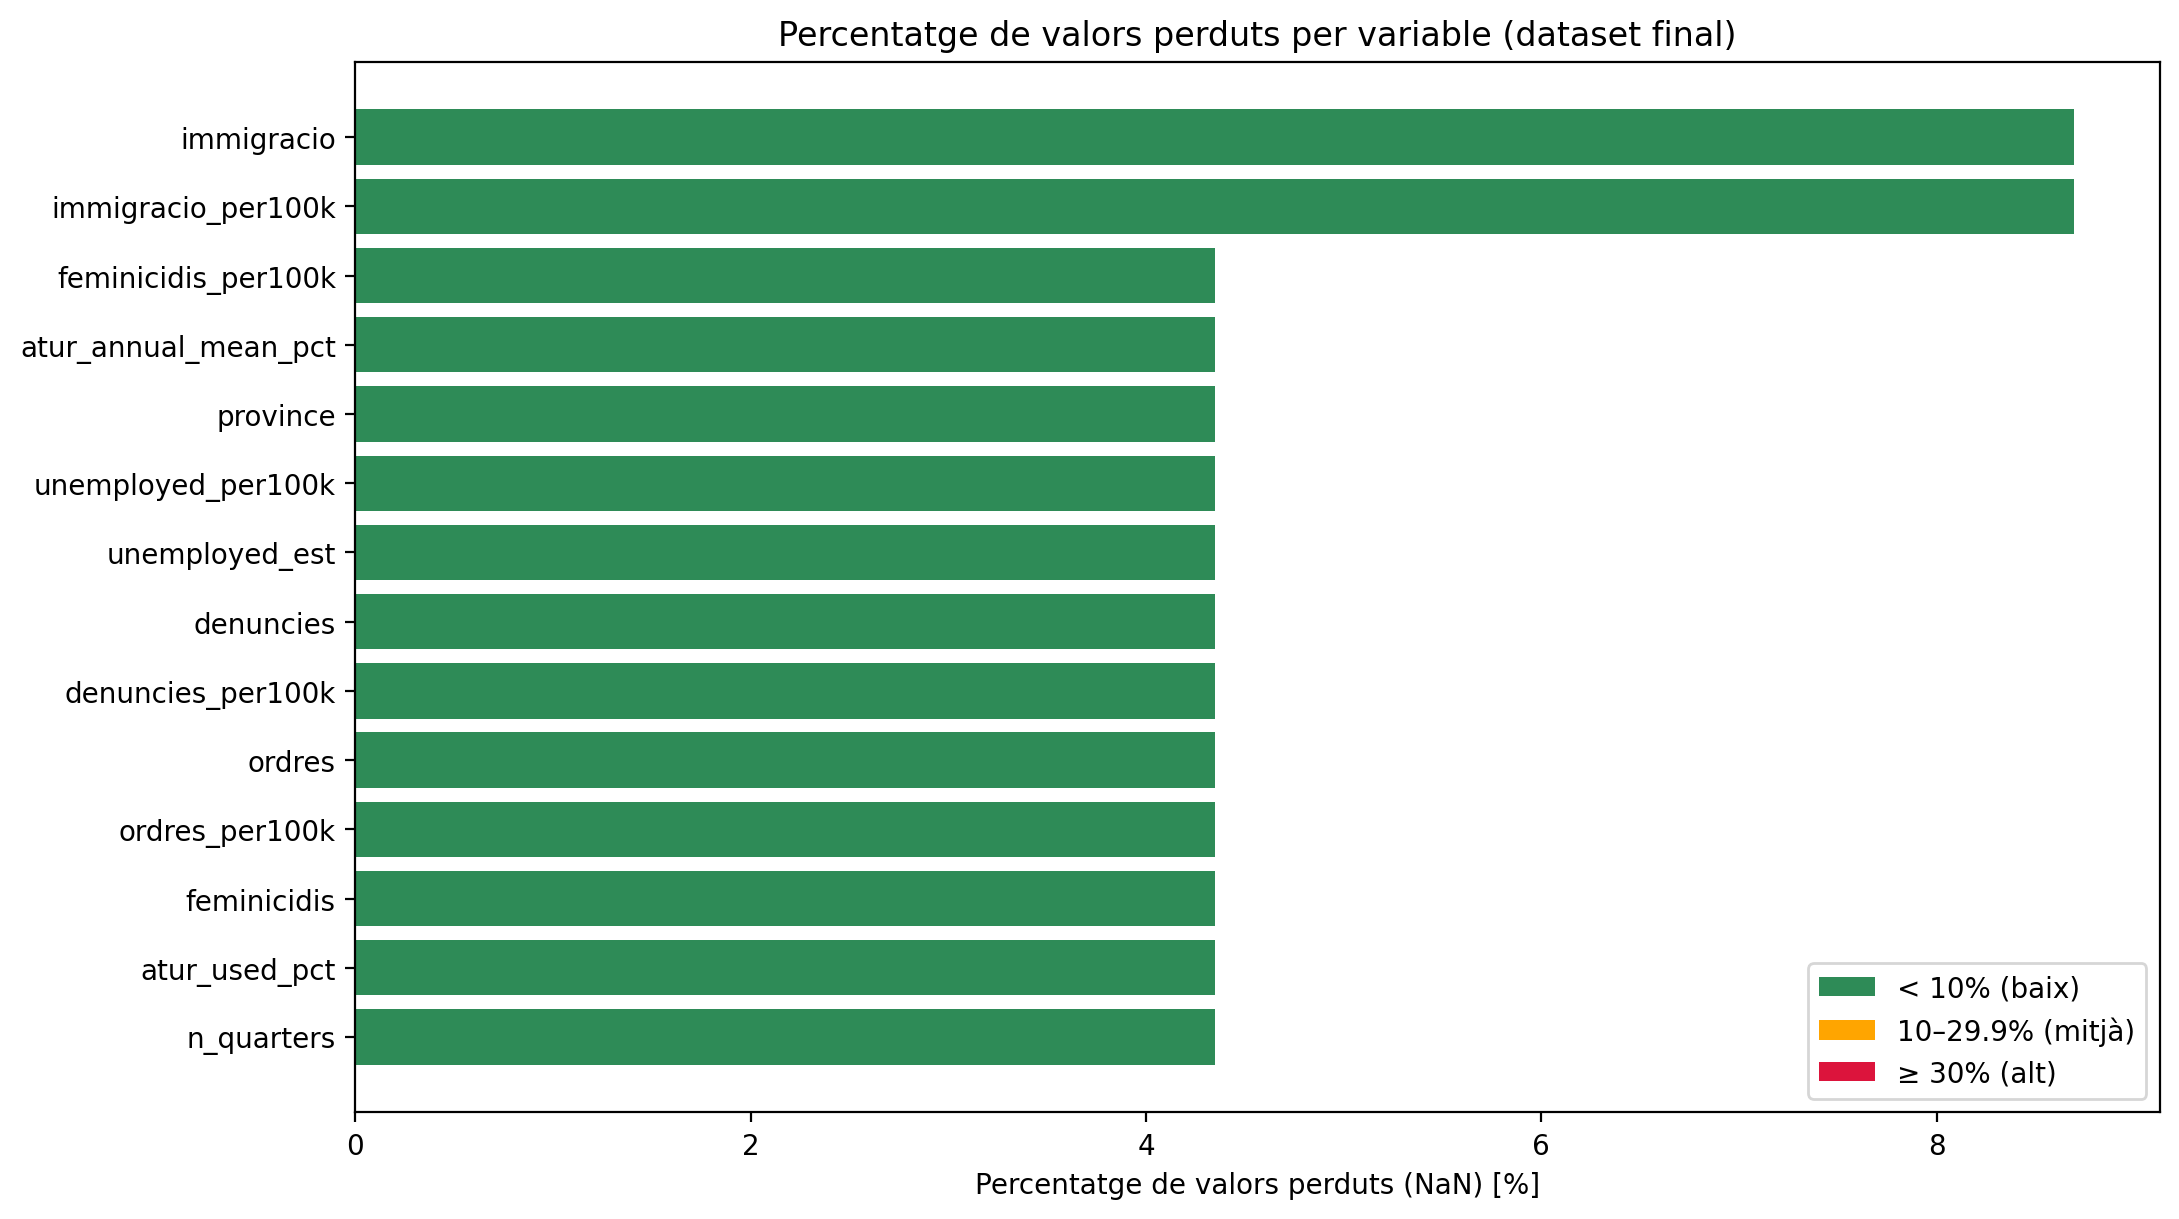

In [19]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

vals = missing_tbl_plot["pct_missing"]

def color_for(p):
    if p >= 30:
        return "crimson"     # crític
    elif p >= 10:
        return "orange"      # alerta
    else:
        return "seagreen"    # acceptable

colors = [color_for(p) for p in vals]

plt.figure(figsize=(11, 6.2), dpi=200)
plt.barh(missing_tbl_plot.index, vals, color=colors)
plt.gca().invert_yaxis()

plt.xlabel("Percentatge de valors perduts (NaN) [%]")
plt.title("Percentatge de valors perduts per variable (dataset final)")

legend_elems = [
    Patch(facecolor="seagreen", label="< 10% (baix)"),
    Patch(facecolor="orange", label="10–29.9% (mitjà)"),
    Patch(facecolor="crimson", label="≥ 30% (alt)"),
]
plt.legend(handles=legend_elems, loc="lower right", frameon=True)

plt.tight_layout()
plt.show()

In [20]:
d = df[["province_norm","year"]].dropna().copy()
years = sorted(d["year"].unique())
print(years[0], years[-1], "n_years =", len(years))

counts_by_prov = d.groupby("province_norm")["year"].nunique().sort_values()
print(counts_by_prov.head(10))
print("Min/Max anys per província:", counts_by_prov.min(), counts_by_prov.max())
print("N total:", len(d), "==", d["province_norm"].nunique(), "*", len(years), "?", len(d) == d["province_norm"].nunique()*len(years))

2000 2024 n_years = 23
province_norm
a coruna      23
las palmas    23
leon          23
lleida        23
lugo          23
madrid        23
malaga        23
melilla       23
murcia        23
navarra       23
Name: year, dtype: int64
Min/Max anys per província: 23 23
N total: 1196 == 52 * 23 ? True


In [21]:
print(df["year"].min(), df["year"].max(), "n_years:", df["year"].nunique())

2000 2024 n_years: 23


In [22]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

path_csv = r"C:\Users\bfeli\3 BBDD inicials\originals\Excels\partials_individuals\rates_all_metrics_by_province_year_unified_final_recomputed_rates.csv"

# Checks clau
print("Shape:", df.shape)
print("Províncies úniques:", df["province_norm"].nunique())
print("Anys únics:", df["year"].nunique(), " | min/max:", df["year"].min(), df["year"].max())

# Duplicats província-any
dups = df.duplicated(subset=["province_norm","year"]).sum()
print("Duplicats province_norm-year:", dups)

# Disponibilitat d'imputacions
cols_interest = [c for c in df.columns if "vote" in c.lower() or "imput" in c.lower() or "flag" in c.lower() or "method" in c.lower()]
print("Columnes candidates:", cols_interest)

Shape: (1196, 29)
Províncies úniques: 52
Anys únics: 23  | min/max: 2000 2024
Duplicats province_norm-year: 0
Columnes candidates: ['population_imputed_from_nearest', 'votes', 'votes_per100k', 'votes_final', 'votes_imputed_method', 'votes_combined', 'votes_source_observed_count', 'votes_imputed_flag', 'votes_original', 'votes_used', 'votes_used_flag', 'votes_per100k_used']


In [23]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Comprovar quins valors té el flag
print(df["votes_used_flag"].value_counts(dropna=False))

# Imputat si el que s'ha utilitzat NO és original
df["is_vote_imputed_used"] = df["votes_used_flag"].astype(str).str.contains("imputed", case=False, na=False)

print(df["is_vote_imputed_used"].value_counts(dropna=False))

votes_used_flag
imputed_used    883
original        313
Name: count, dtype: int64
is_vote_imputed_used
True     883
False    313
Name: count, dtype: int64


TOP 10 províncies (segons votes_used_flag):
             province_norm  n_years  n_imputed  pct_imputed
41  santa cruz de tenerife       23         19    82.608696
0                 a coruna       23         18    78.260870
10                  burgos       23         18    78.260870
24                  huesca       23         18    78.260870
32                  madrid       23         18    78.260870
34                 melilla       23         18    78.260870
37                 ourense       23         18    78.260870
11                 caceres       23         18    78.260870
25           illes balears       23         18    78.260870
7                  badajoz       23         18    78.260870


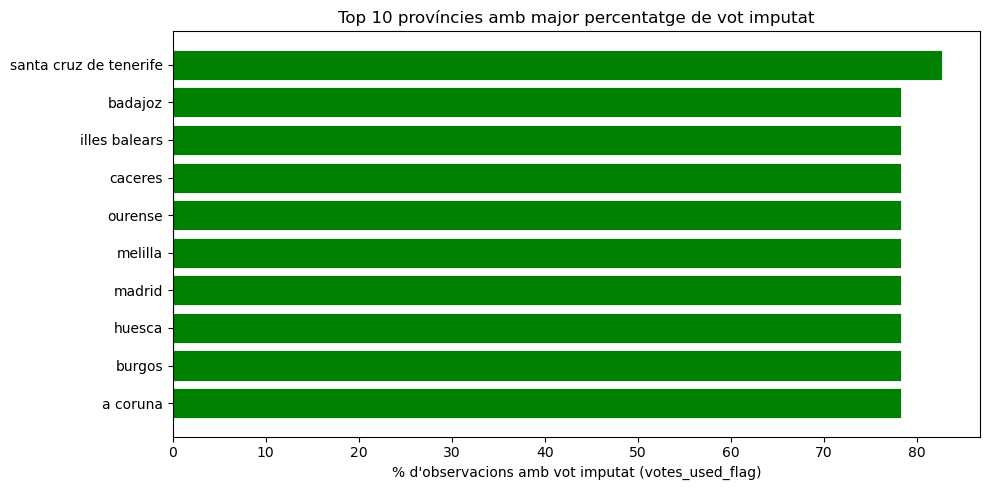

In [24]:
prov_tbl = (
    df.groupby("province_norm")["is_vote_imputed_used"]
      .agg(n_years="size", n_imputed="sum", pct_imputed=lambda s: 100*s.mean())
      .reset_index()
      .sort_values("pct_imputed", ascending=False)
)

print("TOP 10 províncies (segons votes_used_flag):")
print(prov_tbl.head(10)[["province_norm","n_years","n_imputed","pct_imputed"]])

# Figura
top10 = prov_tbl.head(10).sort_values("pct_imputed", ascending=True)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.barh(top10["province_norm"], top10["pct_imputed"], color="green", edgecolor="white", linewidth=0.6)
plt.xlabel("% d'observacions amb vot imputat (votes_used_flag)")
plt.title("Top 10 províncies amb major percentatge de vot imputat")
plt.tight_layout()
plt.show()

In [25]:
import pandas as pd
import numpy as np

PATH_IN  = r"C:\Users\bfeli\3 BBDD inicials\originals\Excels\partials_individuals\rates_all_metrics_by_province_year_unified_final_recomputed_rates.csv"
PATH_OUT = r"C:\Users\bfeli\3 BBDD inicials\originals\Excels\partials_individuals\rates_all_metrics_by_province_year_unified_final_recomputed_rates_FIXED.csv"

df = pd.read_csv(PATH_IN).reset_index(drop=True)
prov_col, year_col = "province", "year"

# Any electorals observats
years_sorted = sorted(df[year_col].unique())
n_years = len(years_sorted)
print("n_years observed:", n_years)
print("years observed:", years_sorted)

# Detectar files corruptes (province NA a 2000)
mask_bad_prov = df[prov_col].isna() | (df[prov_col].astype(str).str.strip().str.lower() == "nan")
mask_bad = mask_bad_prov & (df[year_col] == years_sorted[0])  # normalment 2000
bad_idx = df.index[mask_bad].to_numpy()

print("Files incorrectes:", len(bad_idx))
print("Índex incorrecte:", bad_idx[:10])
print("Index diferents:", np.diff(bad_idx)[:10])

# Validació: el fitxer està en blocs de n_years per província
assert np.all(np.diff(bad_idx) == n_years), "El fitxer no sembla ordenat en blocs nets per província."

df_fixed = df.copy()
df_fixed["_block"] = df_fixed.index // n_years

# Backfill dins de cada bloc: omplir NA de 2000 amb la província del mateix bloc
df_fixed[prov_col] = df_fixed.groupby("_block")[prov_col].transform(lambda s: s.bfill())
df_fixed = df_fixed.drop(columns=["_block"])

# Comprovacions
dups = df_fixed.duplicated([prov_col, year_col]).sum()
print("Provincies NA:", df_fixed[prov_col].isna().sum())
print("Duplicats province-year:", dups)

assert df_fixed[prov_col].isna().sum() == 0
assert dups == 0

df_fixed.to_csv(PATH_OUT, index=False)
print("Desat a:", PATH_OUT)

n_years observed: 23
years observed: [2000, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
Files incorrectes: 52
Índex incorrecte: [  0  23  46  69  92 115 138 161 184 207]
Index diferents: [23 23 23 23 23 23 23 23 23 23]
Provincies NA: 0
Duplicats province-year: 0
Desat a: C:\Users\bfeli\3 BBDD inicials\originals\Excels\partials_individuals\rates_all_metrics_by_province_year_unified_final_recomputed_rates_FIXED.csv


In [26]:
import pandas as pd
import numpy as np

df = pd.read_csv("rates_all_metrics_by_province_year_unified_final_recomputed_rates_FIXED.csv")

print("province NA:", df["province"].isna().sum())
print("duplicats province-year:", df.duplicated(["province","year"]).sum())
print("years:", sorted(df["year"].unique()))
print("files per province (min/max):", df.groupby("province").size().min(), df.groupby("province").size().max())

province NA: 0
duplicats province-year: 0
years: [2000, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
files per province (min/max): 23 23


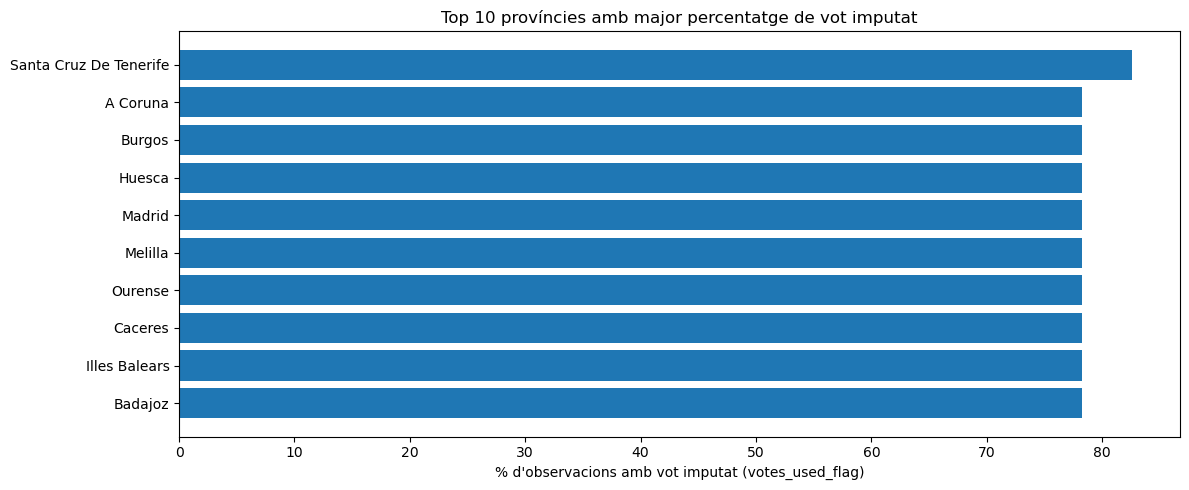

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

PATH = "rates_all_metrics_by_province_year_unified_final_recomputed_rates_FIXED.csv"
df = pd.read_csv(PATH)

df["is_imputed_vote"] = df["votes_used_flag"].astype(str).eq("imputed_used")

top10 = (df.groupby("province")["is_imputed_vote"]
           .mean()
           .sort_values(ascending=False)
           .head(10) * 100)

plt.figure(figsize=(12, 5))
plt.barh(top10.index, top10.values)
plt.gca().invert_yaxis()
plt.xlabel("% d'observacions amb vot imputat (votes_used_flag)")
plt.title("Top 10 províncies amb major percentatge de vot imputat")
plt.tight_layout()
plt.show()

## Les 10 provinces amb major percentatge de vot imputat

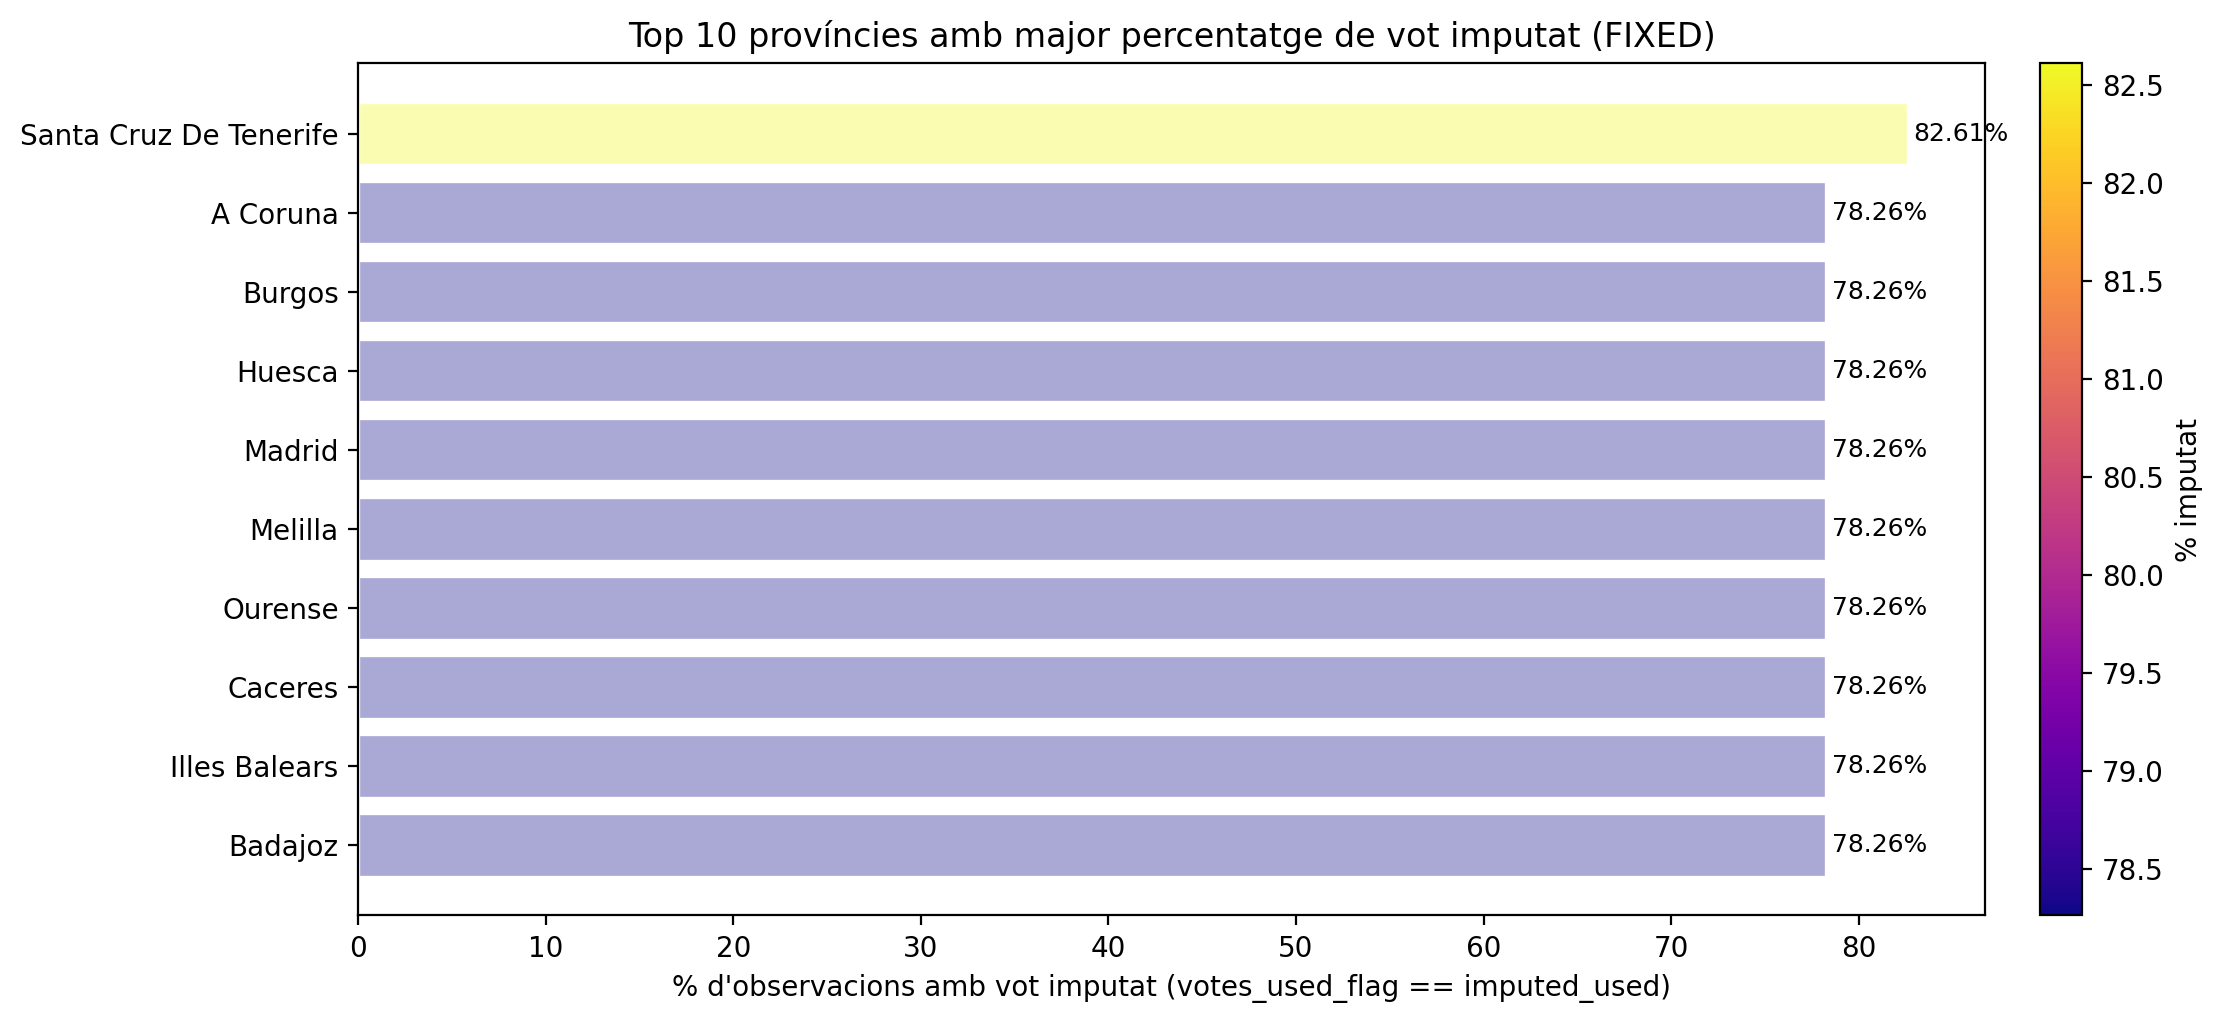

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

PATH = "rates_all_metrics_by_province_year_unified_final_recomputed_rates_FIXED.csv"
df = pd.read_csv(PATH)

df["is_imputed_vote"] = df["votes_used_flag"].astype(str).eq("imputed_used")

top10 = (df.groupby("province")["is_imputed_vote"]
           .mean()
           .sort_values(ascending=False)
           .head(10) * 100)

vals = top10.values

cmap = mpl.cm.get_cmap("plasma")
norm = mpl.colors.Normalize(vmin=vals.min(), vmax=vals.max())
base_colors = cmap(norm(vals))  # RGBA

def pastelize(rgba, amount=0.65):
    rgb = rgba[:, :3]
    rgb_soft = rgb + (1 - rgb) * amount
    return np.c_[rgb_soft, rgba[:, 3]]

colors = pastelize(base_colors, amount=0.65)

fig, ax = plt.subplots(figsize=(11, 5), dpi=200, constrained_layout=True)
ax.barh(top10.index, top10.values, color=colors, edgecolor="white", linewidth=1.2)

ax.invert_yaxis()
ax.set_xlabel("% d'observacions amb vot imputat (votes_used_flag == imputed_used)")
ax.set_title("Top 10 províncies amb major percentatge de vot imputat (FIXED)")

for i, v in enumerate(vals):
    ax.text(v + 0.3, i, f"{v:.2f}%", va="center", fontsize=9)

sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label("% imputat")

plt.show()

## Imputació del vot per provincia i any

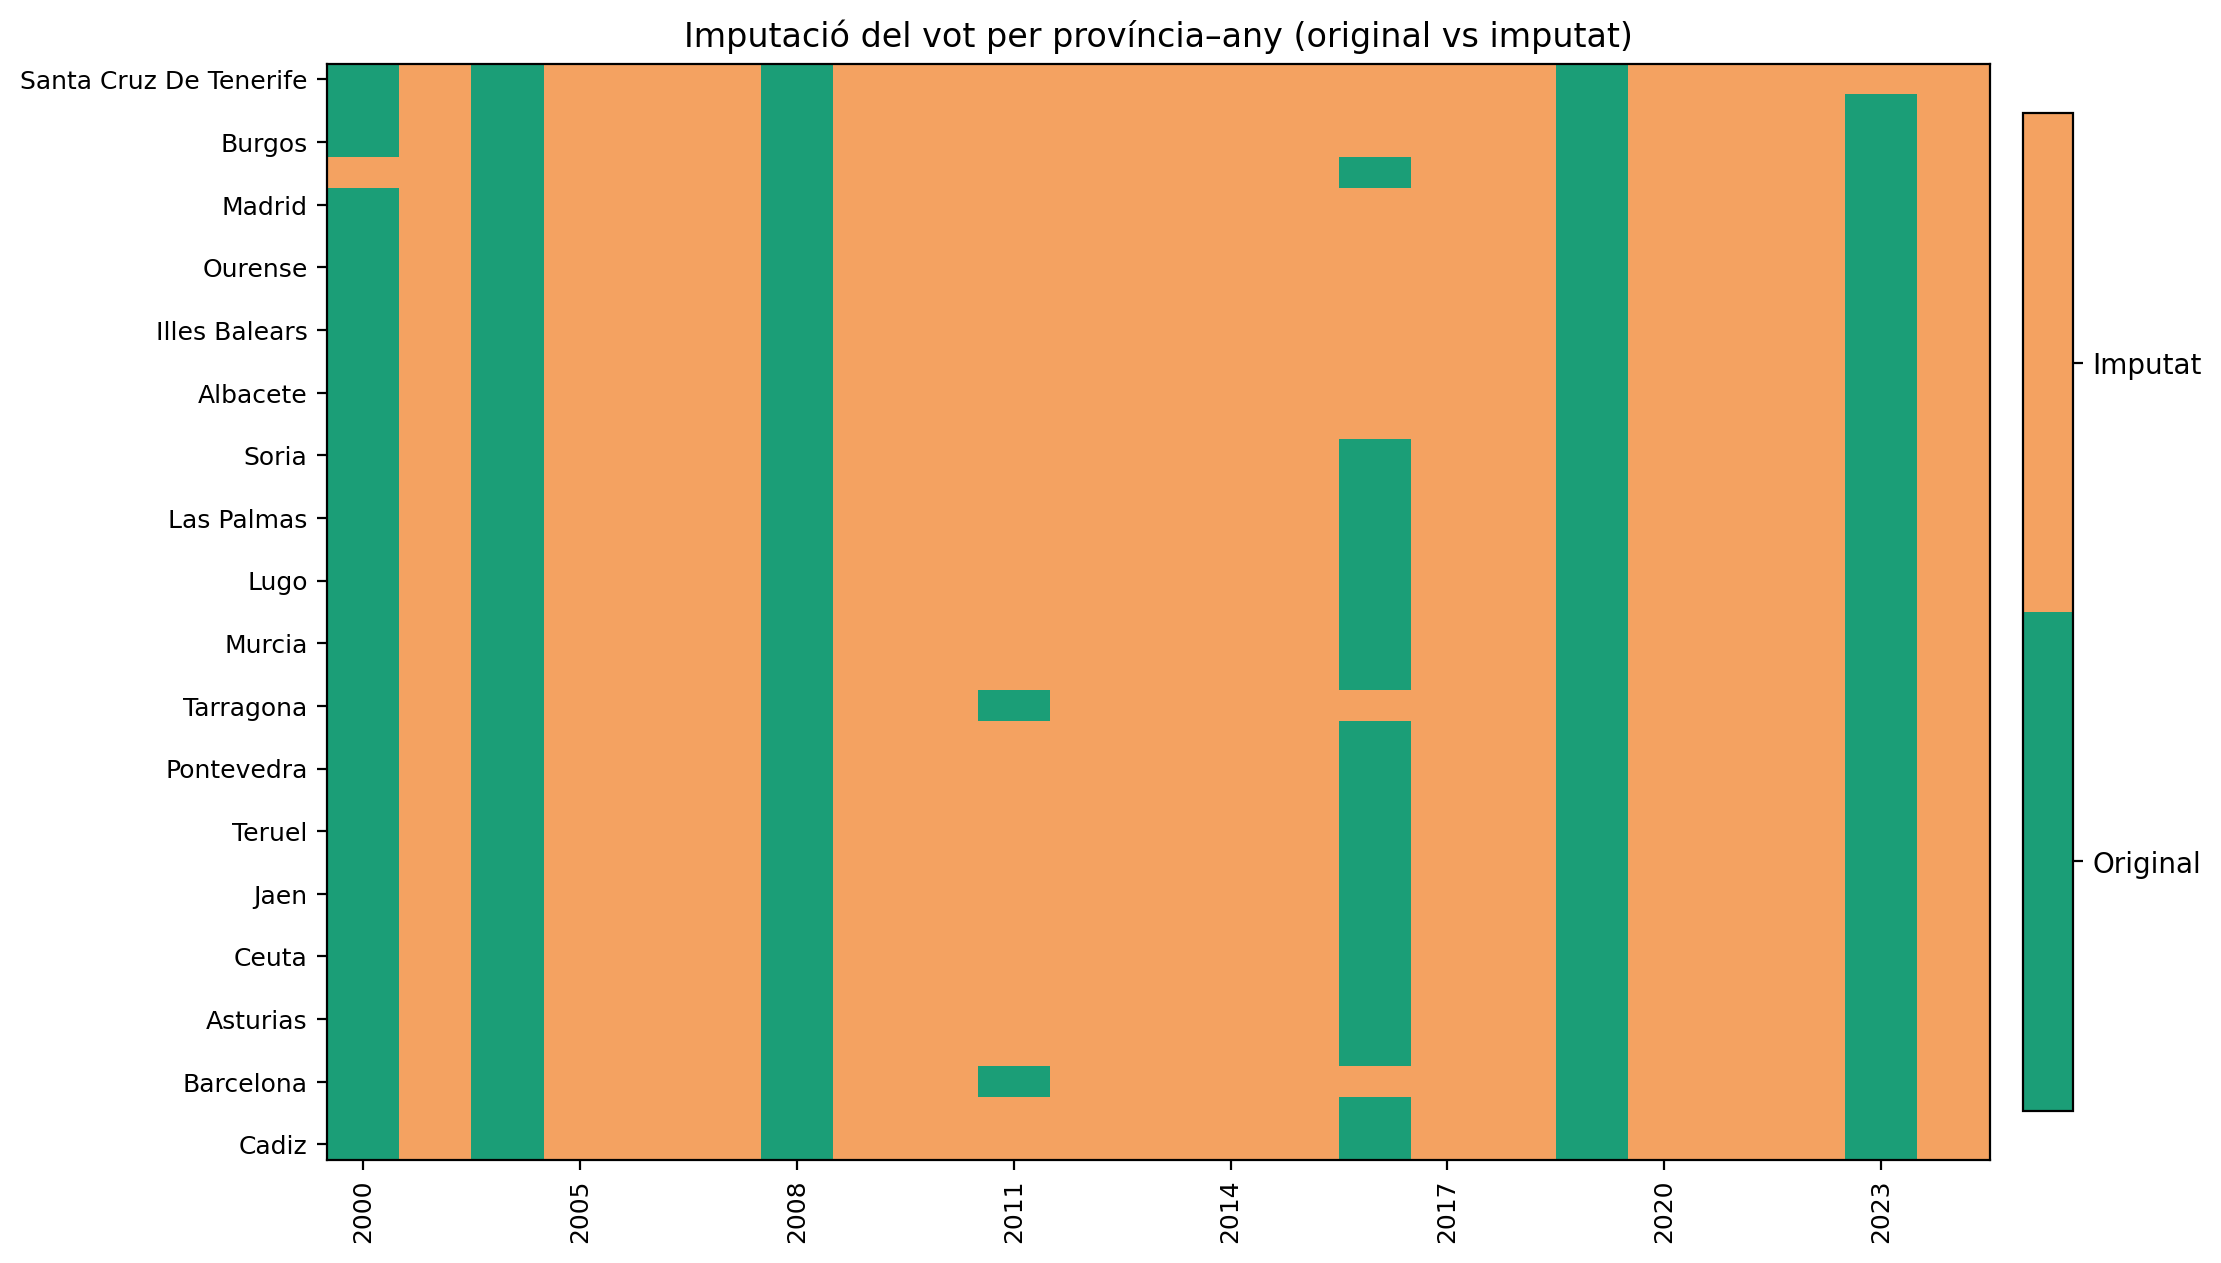

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

PATH = "rates_all_metrics_by_province_year_unified_final_recomputed_rates_FIXED.csv"
df = pd.read_csv(PATH)

df["is_imputed_vote"] = df["votes_used_flag"].astype(str).eq("imputed_used").astype(float)
df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")

heat = df.pivot_table(index="province", columns="year", values="is_imputed_vote", aggfunc="mean")
years = np.sort(df["year"].dropna().unique())
heat = heat.reindex(columns=years)

impute_rate = heat.mean(axis=1, skipna=True).sort_values(ascending=False)
heat = heat.loc[impute_rate.index]

cmap = ListedColormap(["#1b9e77", "#f4a261"])
cmap.set_bad("#efefef")
norm = BoundaryNorm([-0.5, 0.5, 1.5], cmap.N)

TOP_N = 35
heat_plot = heat.head(TOP_N)

fig, ax = plt.subplots(figsize=(11, 6.2), dpi=200, constrained_layout=True)
img = ax.imshow(heat_plot.values, aspect="auto", interpolation="none", cmap=cmap, norm=norm)

years = heat_plot.columns.to_numpy()
step_x = 2 if len(years) <= 20 else 3 if len(years) <= 30 else 4
xt = np.arange(0, len(years), step_x)
ax.set_xticks(xt)
ax.set_xticklabels(years[xt], rotation=90, fontsize=9)

step_y = 1 if heat_plot.shape[0] <= 30 else 2 if heat_plot.shape[0] <= 60 else 3
yt = np.arange(0, heat_plot.shape[0], step_y)
ax.set_yticks(yt)
ax.set_yticklabels(heat_plot.index[yt], fontsize=9)

ax.set_title("Imputació del vot per província–any (original vs imputat)")

cbar = fig.colorbar(img, ax=ax, ticks=[0, 1], fraction=0.03, pad=0.02)
cbar.ax.set_yticklabels(["Original", "Imputat"])

plt.show()

## Percentatge de valors perduts per variable

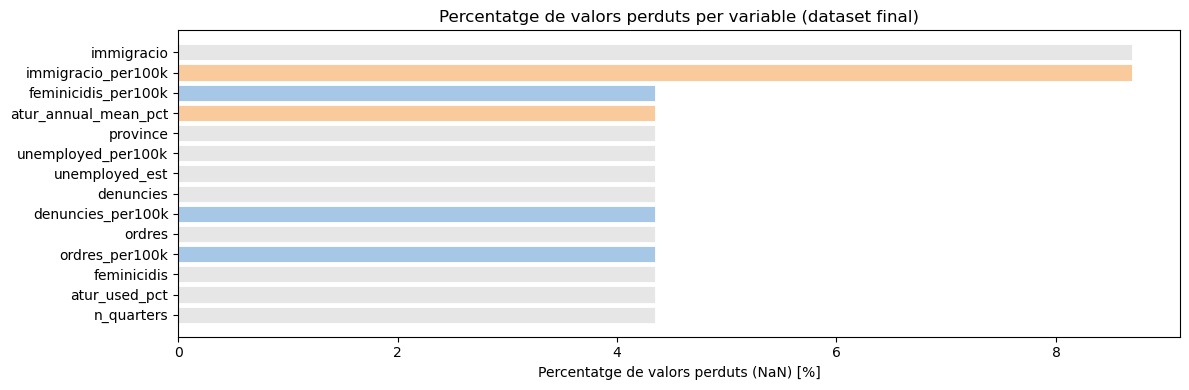

In [30]:
import matplotlib.pyplot as plt

outcomes = {"denuncies_per100k", "ordres_per100k", "feminicidis_per100k"}
vote = {"votes_per100k_used"}
controls = {"immigracio_per100k", "atur_annual_mean_pct"}

def pastel_color(colname: str) -> str:
    if colname in outcomes:
        return "#A7C7E7"  # blau pastel
    if colname in vote:
        return "#B6D7A8"  # verd pastel
    if colname in controls:
        return "#F9CB9C"  # taronja pastel
    return "#E6E6E6"      # gris clar

colors = [pastel_color(c) for c in missing_tbl_plot.index]

plt.figure(figsize=(12, max(4, 0.28 * len(missing_tbl_plot))))
plt.barh(missing_tbl_plot.index, missing_tbl_plot["pct_missing"], color=colors, edgecolor="white", linewidth=0.6)
plt.gca().invert_yaxis()
plt.xlabel("Percentatge de valors perduts (NaN) [%]")
plt.title("Percentatge de valors perduts per variable (dataset final)")
plt.tight_layout()
plt.show()

In [31]:
fig_path = os.path.join(out_dir, "Fig10_missingness_pct.png")
plt.savefig(fig_path, dpi=300)
print(f"\nTaula desada a: {os.path.join(out_dir, 'missingness_by_column.csv')}")
print(f"Figura desada a: {fig_path}")


Taula desada a: output_qc\missingness_by_column.csv
Figura desada a: output_qc\Fig10_missingness_pct.png


<Figure size 640x480 with 0 Axes>

In [32]:
top10 = (
    missing_tbl.reset_index()
    .rename(columns={"index": "variable"})
    .loc[:, ["variable", "n_missing", "pct_missing"]]
    .head(10)
)

top10["pct_missing"] = top10["pct_missing"].round(2)
top10

,variable,n_missing,pct_missing
0,immigracio,104,8.70
1,immigracio_per100k,104,8.70
2,feminicidis_per100k,52,4.35
3,atur_annual_mean_pct,52,4.35
4,province,52,4.35
5,unemployed_per100k,52,4.35
6,unemployed_est,52,4.35
7,denuncies,52,4.35
8,denuncies_per100k,52,4.35
9,ordres,52,4.35
